In [ ]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

import statsmodels.api as sm
from scipy.stats import norm

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024"

# Data preocessing

## Process Parker cohort

In [7]:
#Readin samples from Parker cohort of Infinity TB all_cols.csv file shared by Jing 
df_parker = pd.read_csv("/ghsfa/projects/pharma/customers/ParkerInstitutePICI/Infinity/PIC_RP_01_Infinity/PIC_RP_01_Infinity_02/data/report/3rd_run/12252023_PIC_RP01_02_tb_changed_all_cols.csv", header = 1) 

print("Total sample size of Parker cohort is " + str(df_parker.shape[0]) + "\n") 
print("Total unique sample size of Parker cohort is " + str(df_parker.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of Parker cohort is " + str(df_parker.Patient_ID.nunique()) + "\n")
df_parker.head()

Total sample size of Parker cohort is 105742

Total unique sample size of Parker cohort is 1409

Total unique patient sample size of Parker cohort is 548



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Study ID,Patient ID,Customer Sample ID,Sample Time point,plasma_volume_manifest,Sample Type,Cancer Stage,requestcreatedt,bloodcolldate,sample_received_date,cancerother,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,plasma_volume_observed,Batch_ID,new_Cancertype,Cancer_Type_in_Cohort,new_Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_Standardized,call,ldt_reportable,ruo_reportable,variant_comment,Final_RUO_call,on_OMNI,on_G360,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,cn_deletion_sample_comment,cnv_tumor_fraction,hyper_score,on_target_dmr_count,off_target_dmr_count,total_dmr_count,hyper_flag,runid,chry_nonsingleton,contam_vscore,dinucleosome_peak,dm_probes,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_95_lower,methyl_95_upper,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,sample_contamination_pct,sample_coverage_exceptions_ldt,warning,num_fusion_in_homdel,num_somvar_in_homdel,methyl_pos_capture_min
0,PICI0009,BK14846EP01,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,SESN2,1,28595751.0,2.0,V50M,G>A,c.148G>A,NM_031459.5,52.98,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV53429244,rs148732943,NaN,NaN,NaN,NaN,3223.0,19.56,NaN,NaN,Detected,0.110817,11.34,Low,Not Detected,18.616,1.0,0.0,03/14/2023,08/07/2020,12/25/2023,Urothelial carcinoma (UC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1309,BK14846EP01,12 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,08/07/2020,03/14/2023,Urothelial carcinoma (UC),NaN,ACCCATTGCA,GGTCCTCTCA,Shortened_Targeted_SEQ,EIO_PlateI_A11,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,A11,1.0,PS3C-255,Urothelial carcinoma (UC),NaN,NaN,NaN,NaN,1.0,0.0,1.0,germline pval,1.0,Yes,No,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.248991,3.0,2.0,BREAST,24.64775,37.1925,24.64775,20.74831,22.46395,6,NaN,0.19,6,77,0,77,NaN,231118_A01907_0174_BHKJHYDSX7,0.0,2.0,322.0,77.0,0.00133,2766.0,1.246,0.83,0.04,12.0,12.0,133364.0,0.000037,1.21366,0.02,2.0,NaN,NaN,NaN,1.21366
1,PICI0009,BK14846EP01,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,KMT2B,19,36223413.0,28.0,A1988G,C>G,c.5963C>G,NM_014727.3,52.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3042.0,19.56,NaN,NaN,Detected,0.110817,11.34,Low,Not Detected,18.616,1.0,0.0,03/14/2023,08/07/2020,12/25/2023,Urothelial carcinoma (UC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1309,BK14846EP01,12 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,08/07/2020,03/14/2023,Urothelial carcinoma (UC),NaN,ACCCATTGCA,GGTCCTCTCA,Shortened_Targeted_SEQ,EIO_PlateI_A11,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,A11,1.0,PS3C-255,Urothelial carcinoma (UC),NaN,NaN,NaN,NaN,1.0,0.0,1.0,germline pval,1.0,No,No,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.248991,3.0,2.0,BREAST,24.64775,37.19

In [8]:
#Readin a subset Parker samples. Mingyang selected 914 out of 1409 samples as no QC warnings triggered.
#MY also ran the MB Lung v1, MB pan cancer caller on those 914 samples and added some columns to indicate the result
df_parker_clean = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer/parker_914_clean_samples_meta.csv", header = 0) 

print("Total sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.shape[0]) + "\n") 
print("Total unique sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.Patient_ID.nunique()) + "\n")
df_parker_clean.head()

Total sample size of Parker cohort w/t QC warnings is 914

Total unique sample size of Parker cohort w/t QC warnings is 914

Total unique patient sample size of Parker cohort w/t QC warnings is 463



,warning,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,HRD_score,hrd_status,Max_percentage,cfDNA_ng,Plasma_ml_input,Cancertype,fc_dir,runid,chry_nonsingleton,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,cn_deletion_sample_comment,new_Cancertype,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,methyl_95_lower,methyl_95_upper,dinucleosome_peak,dm_probes,on_target_dmr_count,off_target_dmr_count,run_sample_id,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,methyl_call_LR_Aggregated,new_Visit_name
0,NaN,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,Detected,0.110817,11.34,Low,Not Detected,NaN,HRD_Neg,19.56,18.616,1.0,Urothelial carcinoma (UC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,2.0,0.00133,2766.0,1.246,0.83,0.04,133364.0,0.000037,1.21366,1.21366,0.02,NaN,Urothelial carcinoma (UC),BREAST,24.64775,37.19250,24.64775,20.74831,22.46395,12.0,12.0,322.0,77.0,77,0,B00538703,11.477615,-20.032878,1,8.147645,-20.86299,1,1,12 months post 1st dose
1,NaN,A0723616,B00538698,PICI0009.PICI0009-3-1773,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.005843,30.81,High,Not Detected,NaN,HRD_Neg,0.58,8.528,1.0,Urothelial carcinoma (UC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,0.0,0.00000,1248.0,1.422,0.84,0.06,63071.0,0.000396,1.21098,1.21098,0.02,NaN,Urothelial carcinoma (UC),LUNG,10.42780,23.50968,8.35169,3.48606,10.42780,12.0,12.0,324.0,0.0,0,0,B00538698,-6.316503,-20.032878,1,-2.500514,-20.86299,1,1,pre-treatment
2,NaN,A0723615,B00538701,PICI0009.PICI0009-3-1721,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.000910,7.56,Low,Not Detected,NaN,HRD_Neg,6.26,7.436,1.0,Bladder cancer,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,0.0,0.00000,987.0,2.003,0.84,0.06,52108.0,0.000038,1.23931,1.23931,0.02,NaN,Bladder cancer,LUNG,0.05464,-0.03561,-14.06017,-10.61117,0.05464,12.0,12.0,319.0,1.0,0,1,B00538701,-21.017365,-20.032878,0,-21.892035,-20.86299,0,1,pre-treatment
3,NaN,A0723613,B00538687,PICI0009.PICI0009-3-1007,4-6 WEEKS POST EOSI,1,SUCCESS,NaN,Detected,0.001187,16.32,Low,Not Detected,NaN,HRD_Neg,0.81,6.136,1.0,Renal cell carcinoma (RCC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,1.0,0.00411,968.0,1.071,0.85,0.05,43561.0,0.000207,1.22899,1.22899,0.02,NaN,Renal cell carcinoma (RCC),LUNG,0.29922,4.37834,-0.29118,-2.92178,0.29922,12.0,12.0,321.0,0.0,0,0,B00538687,-18.545455,-20.032878,1,-22.245143,-20.86299,0,1,4-6 weeks post eosi
4,NaN,A0723611,B00538690,PICI0009.PICI0009-3-1772,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.669596,8.51,Low,Detected,NaN,HRD_Pos,54.65,483.600,1.0,Prostate cancer,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,4.0,0.00153,2968.0,0.970,0.85,0.09,107226.0,0.000019,1.27363,1.27363,0.02,NaN,Prostate cancer,BREAST,42.03898,15.37511,42.03898,24.49356,26.79190,12.0,12.0,299.0,372.0,345,27,B00538690,14.107403,-20.032878,1,12.676551,-20.86299,1,1,pre-treatment


Total sample size wtih positive on MB pan-cancer caller is 538

Total sample size wtih positive on MB lung v1 caller is 573

Total sample size wtih positive on LR aggregative caller is 571



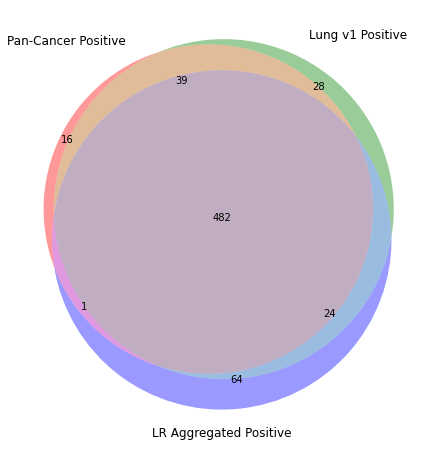

Total sample size used for ISD is 98

Total sample size used for ISD with MB/LR caller info is 98



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Study ID,Patient ID,Customer Sample ID,Sample Time point,plasma_volume_manifest,Sample Type,Cancer Stage,requestcreatedt,bloodcolldate,sample_received_date,cancerother,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,plasma_volume_observed,Batch_ID,new_Cancertype,Cancer_Type_in_Cohort,new_Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_Standardized,call,ldt_reportable,ruo_reportable,variant_comment,Final_RUO_call,on_OMNI,on_G360,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,cn_deletion_sample_comment,cnv_tumor_fraction,hyper_score,on_target_dmr_count,off_target_dmr_count,total_dmr_count,hyper_flag,runid,chry_nonsingleton,contam_vscore,dinucleosome_peak,dm_probes,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_95_lower,methyl_95_upper,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,sample_contamination_pct,sample_coverage_exceptions_ldt,warning,num_fusion_in_homdel,num_somvar_in_homdel,methyl_pos_capture_min,maf
2317,PICI0009,BK15032EP01,A0723584,B00538617,PICI0009.PICI0009-3-1876,PRE-TREATMENT,1,SUCCESS,NaN,SNV,NaN,PIK3CA,3,178952085.0,21.0,H1047R,A>G,c.3140A>G,NM_006218.4,14.60,NaN,somatic,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55873195,rs121913279,Pathogenic,28691.0,deleterious,NaN,4693.0,16.27,NaN,NaN,Detected,0.083369,6.62,Low,Not Detected,29.016,1.0,0.0,03/14/2023,09/25/2020,12/25/2023,Breast cancer,Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1876,BK15032EP01,PRE-TREATMENT,1.0,Plasma,NaN,04/13/2023,09/25/2020,03/14/2023,Breast cancer,NaN,AAAGTATTCG,AAATAGGGTC,Shortened_Targeted_SEQ,EIO_PlateI_F6,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0175_AHKJMMDSX7_PS3C255_AP2.Sirius-1.1.1-RLS,F6,1.0,PS3C-255,Breast cancer,NaN,NaN,NaN,NaN,1.0,1.0,1.0,whitelist_Tier2; cancer_hotspot; ldt_reportable,1.0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,HRD_Pos,0.332700,10.0,0.0,BREAST,49.78998,17.37399,49.78998,-11.69869,17.50793,7,NaN,0.14,7,18,0,18,NaN,231118_A01907_0175_AHKJMMDSX7,0.0,5.0,312.0,18.0,0.00109,3837.0,1.446,0.84,0.04,12.0,12.0,182187.0,0.000027,1.24476,0.02,0.0,NaN,NaN,NaN,1.24476,0.1460
4424,PICI0009,BK15071EP01,A0723557,B00538642,PICI0009.PICI0009-3-1528,6 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,PIK3CA,3,178936091.0,10.0,E545K,G>A,c.1633G>A,NM_006218.4,10.84,NaN,somatic,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55873239,rs104886003,Pathogenic/Likely_pathogenic,28694.0,NaN,NaN,1039.0,10.84,NaN,NaN,Detected,0.090148,11.34,Low,Not Detected,6.292,1.0,0.0,03/14/2023,07/28/2020,12/25/2023,Head and neck squamous cell cancer (HNSCC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1528,BK15071EP01,6 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,07/28/2020,03/14/2023,Head and neck squamous cell cancer (HNSCC),NaN,TTCGTGAGAT,ACAAAGCTTC,Shortened_Targeted_SEQ,EIO_PlateI_C3,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01810_0259_BHKJNMDSX7_PS3C255_AP1.Sirius-1.1.1-RLS,C3,1.0,PS3C-255,Head and neck squamous cell cancer (HNSCC),NaN,NaN

In [9]:
# !pip install matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

#select in silico patient samples (MB pos + max-maf > 1% but < 15% + non-TP53 + non-synonymous + whitelist_tier1/2 )

#check positivity conditions on 914 Parker samples
df_parker_clean_1 = df_parker_clean.copy()

df_parker_clean_pan_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_MB_Pan_Cancer"] == 1]
print("Total sample size wtih positive on MB pan-cancer caller is " + str(df_parker_clean_pan_pos.shape[0]) + "\n") 
df_parker_clean_lung_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_MB_Lung_v1"] == 1]
print("Total sample size wtih positive on MB lung v1 caller is " + str(df_parker_clean_lung_pos.shape[0]) + "\n") 
df_parker_clean_LR_agg_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_LR_Aggregated"] == 1]
print("Total sample size wtih positive on LR aggregative caller is " + str(df_parker_clean_LR_agg_pos.shape[0]) + "\n") 

#plot venn diagram to check the overlapping
pan_pos_ids = set(df_parker_clean_pan_pos['GHSampleID'])
lung_pos_ids = set(df_parker_clean_lung_pos['GHSampleID'])
lr_agg_pos_ids = set(df_parker_clean_LR_agg_pos['GHSampleID'])
plt.figure(figsize=(8, 8), facecolor='white')
venn = venn3([pan_pos_ids, lung_pos_ids, lr_agg_pos_ids], ('Pan-Cancer Positive', 'Lung v1 Positive', 'LR Aggregated Positive'))
plt.show()

#select MB pancancer pos samples and max-maf > 1% and non-TP53
df_candidate_1 = df_parker_clean_pan_pos[df_parker_clean_pan_pos["Max_percentage"] > 1] 
#print(df_candidate_1.shape)

#subset the df_candidate_1 samples from the original Parker cohort to access columns "on_G360", "Gene", "Percentage" and "Somatic_status" etc.
sample_list_candi_1 = df_candidate_1.GHSampleID.tolist()
df_parker_candi_1 = df_parker[df_parker.GHSampleID.isin(sample_list_candi_1)]
#print(df_cosmos_MB_rerun_shedding.GHSampleID.nunique())

df_parker_candi_1 = df_parker_candi_1[(df_parker_candi_1["on_G360"] == "Yes") & (df_parker_candi_1["Gene"] != "TP53") & (df_parker_candi_1["Somatic_status"] == "somatic") & (df_parker_candi_1["Percentage"] > 1) & (df_parker_candi_1["Percentage"] < 15) & (df_parker_candi_1["Molecular_consequence"] != "synonymous")]  
df_parker_isd = df_parker_candi_1[df_parker_candi_1["variant_comment"].str.contains("whitelist_Tier1|whitelist_Tier2")]

df_parker_isd = df_parker_isd.loc[df_parker_isd.groupby('GHSampleID')['Percentage'].idxmax()]
df_parker_isd['maf'] = df_parker_isd['Percentage'] / 100
#print(df_parker_isd.GHSampleID.nunique())
print("Total sample size used for ISD is " + str(df_parker_isd.shape[0]) + "\n") 

#select the MB pancancer pos samples and max-maf > 1% and non-TP53
sample_list_candi_2 = df_parker_isd.GHSampleID.tolist()
df_parker_candi_2 = df_parker_clean_pan_pos[df_parker_clean_pan_pos.GHSampleID.isin(sample_list_candi_2)]
print("Total sample size used for ISD with MB/LR caller info is " + str(df_parker_candi_2.shape[0]) + "\n") 

#save the Parker ISD cohort
df_parker_isd.to_csv(f"{work_dir}/df_parker_ISD.csv", index=False) 
df_parker_clean.to_csv(f"{work_dir}/914_parker_samples.csv", index=False) 

df_parker_isd.head()

## Process MRD AV cohort

In [15]:
#Readin samples from MRD AV cohort for LoQ analysis
df_av_loq = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/s3av_loq_samples_meta.csv", header = 0) 

print("Total sample size of MRD AV LoQ cohort is " + str(df_av_loq.shape[0]) + "\n") 
print("Total unique sample size of MRD AV LoQ cohort is " + str(df_av_loq.run_sample_id.nunique()) + "\n")
print("Total unique patient sample size of MRD AV LoQ cohort is " + str(df_av_loq.run_sample_id.nunique()) + "\n")
df_av_loq.head()

Total sample size of MRD AV LoQ cohort is 752

Total unique sample size of MRD AV LoQ cohort is 752

Total unique patient sample size of MRD AV LoQ cohort is 752



,run_sample_id,runid,batch_id,well_id,request_id,type,cancer_type,input,target_maf_pct,hyper_residual_count_pos_ctrl,ctrl_cor_frac,methyl_hyper_pos_highcg_count,hotspot_non_singleton_coverage,model_name,methyl_score_LR_Aggregated,methyl_call_LR_Aggregated,pred_type,pred_frac,analysis_version,fc_path,GHSampleID,fc_dir,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer
0,KM12_20_15_R1,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,G:1,KM12,cell_line,CRC,15,20.0,52125,1.73833,90472,2271,AGGREGATED,41.59566,1,CRC,0.581942,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,KM12_20_15_R1,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,3.283640,-20.032878,1,6.171024,-20.86299,1
1,H1648_20_15_R1,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,F:2,H1648,cell_line,LUNG,15,20.0,46923,1.92638,88413,2067,AGGREGATED,36.09576,1,LUNG,0.198296,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H1648_20_15_R1,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,16.635510,-20.032878,1,8.314513,-20.86299,1
2,H2218_20_15_R3,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,A:4,HCC2218,cell_line,BREAST,15,20.0,72597,1.57112,112531,2325,AGGREGATED,43.12771,1,BREAST,0.349826,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H2218_20_15_R3,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,19.337575,-20.032878,1,13.872918,-20.86299,1
3,H2218_20_15_R2,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,D:4,HCC2218,cell_line,BREAST,15,20.0,63477,1.77381,111680,1936,AGGREGATED,41.78230,1,BREAST,0.343807,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H2218_20_15_R2,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,18.660438,-20.032878,1,13.275043,-20.86299,1
4,H1648_20_15_R2,230526_A01902_0148_BH3WW3DSX7,S3AV-74-LDT,F:5,H1648,cell_line,LUNG,15,20.0,47053,1.97955,91089,2001,AGGREGATED,35.51657,1,LUNG,0.211016,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0148_BH3WW3DSX7.S3AV_74_LDT_LOD2.Sirius-1.5.0-RC0_20231115-120242,H1648_20_15_R2,/ghds/omni_v2/flowcells//230526_A01902_0148_BH3WW3DSX7.S3AV_74_LDT_LOD2.Sirius-1.5.0-RC0_20231115-120242/sirius_1_5_0_rc0_tar/,16.718688,-20.032878,1,7.884320,-20.86299,1


In [16]:
#select ISD analysis from MRD AV LoQ analysis data (section 9.6.4 of this report: https://docs.google.com/document/d/16z-1MJ1ROeMogk4_wtpJ3g_rShoCvlEj/edit)

#check positivity conditions on 752 MRD AV LoQ analysis samples
df_av_loq_1 = df_av_loq.copy()

df_av_loq_pan_pos = df_av_loq_1[df_av_loq_1["methyl_call_MB_Pan_Cancer"] == 1]
print("Total sample size wtih positive on MB pan-cancer caller is " + str(df_av_loq_pan_pos.shape[0]) + "\n") 

#select MB pancancer pos samples and max-maf > 1%
df_av_loq_isd = df_av_loq_1[df_av_loq_1["target_maf_pct"] >= 1] 
print("Total sample size used for ISD from MRD AV LoQ samples is " + str(df_av_loq_isd.shape[0]) + "\n") 

df_av_loq_isd["maf"] = df_av_loq_isd["target_maf_pct"] / 100
df_av_loq_isd.head()

Total sample size wtih positive on MB pan-cancer caller is 706

Total sample size used for ISD from MRD AV LoQ samples is 136



,run_sample_id,runid,batch_id,well_id,request_id,type,cancer_type,input,target_maf_pct,hyper_residual_count_pos_ctrl,ctrl_cor_frac,methyl_hyper_pos_highcg_count,hotspot_non_singleton_coverage,model_name,methyl_score_LR_Aggregated,methyl_call_LR_Aggregated,pred_type,pred_frac,analysis_version,fc_path,GHSampleID,fc_dir,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,maf
0,KM12_20_15_R1,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,G:1,KM12,cell_line,CRC,15,20.0,52125,1.73833,90472,2271,AGGREGATED,41.59566,1,CRC,0.581942,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,KM12_20_15_R1,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,3.283640,-20.032878,1,6.171024,-20.86299,1,0.2
1,H1648_20_15_R1,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,F:2,H1648,cell_line,LUNG,15,20.0,46923,1.92638,88413,2067,AGGREGATED,36.09576,1,LUNG,0.198296,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H1648_20_15_R1,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,16.635510,-20.032878,1,8.314513,-20.86299,1,0.2
2,H2218_20_15_R3,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,A:4,HCC2218,cell_line,BREAST,15,20.0,72597,1.57112,112531,2325,AGGREGATED,43.12771,1,BREAST,0.349826,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H2218_20_15_R3,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,19.337575,-20.032878,1,13.872918,-20.86299,1,0.2
3,H2218_20_15_R2,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,D:4,HCC2218,cell_line,BREAST,15,20.0,63477,1.77381,111680,1936,AGGREGATED,41.78230,1,BREAST,0.343807,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H2218_20_15_R2,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,18.660438,-20.032878,1,13.275043,-20.86299,1,0.2
4,H1648_20_15_R2,230526_A01902_0148_BH3WW3DSX7,S3AV-74-LDT,F:5,H1648,cell_line,LUNG,15,20.0,47053,1.97955,91089,2001,AGGREGATED,35.51657,1,LUNG,0.211016,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0148_BH3WW3DSX7.S3AV_74_LDT_LOD2.Sirius-1.5.0-RC0_20231115-120242,H1648_20_15_R2,/ghds/omni_v2/flowcells//230526_A01902_0148_BH3WW3DSX7.S3AV_74_LDT_LOD2.Sirius-1.5.0-RC0_20231115-120242/sirius_1_5_0_rc0_tar/,16.718688,-20.032878,1,7.884320,-20.86299,1,0.2


In [17]:
#Readin samples from MRD AV cohort for Accuracy analysis
df_av_acc = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/s3av_accuracy_samples_meta.csv", header = 0) 

print("Total sample size of MRD AV Accuracy cohort is " + str(df_av_acc.shape[0]) + "\n") 
print("Total unique sample size of MRD Accuracy LoQ cohort is " + str(df_av_acc.run_sample_id.nunique()) + "\n")
print("Total unique patient sample size of MRD Accuracy LoQ cohort is " + str(df_av_acc.run_sample_id.nunique()) + "\n")
df_av_acc.head()

Total sample size of MRD AV Accuracy cohort is 266

Total unique sample size of MRD Accuracy LoQ cohort is 266

Total unique patient sample size of MRD Accuracy LoQ cohort is 266



,run_sample_id,runid,cancertype,cancertype_8,hyper_residual_count_pos_ctrl,sample_pass,methyl_call_LR_Aggregated,pred_frac,pred_type,max_maf_AI_TF,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_variant_comment,max_maf_gene_cn,AI_TF,rms,fc_dir,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,TF_group
0,Accu_HRD10_4507,230502_A00274_0841_BH3V72DSX7,Colorectal adenocarcinoma,Colorectal adenocarcinoma,84383,True,1,0.425798,CRC,0.710300,0.7103,KRAS,G12C,whitelist_Tier1; drug_resistance; snp called in gene; somatic call above 70%; ldt_reportable,NaN,0.608656,19.466440,/ghds/omni_v2/flowcells/230502_A00274_0841_BH3V72DSX7.S3AV58LDT_AP3.Sirius-1.5.0-RC0_20231115-153507/sirius_1_5_0_rc0_tar/,6.367888,-20.032878,1,13.195671,-20.86299,1,High TF
1,Accu_HRD1_3057,230502_A00274_0840_AH3TY7DSX7,Lung adenocarcinoma,Lung adenocarcinoma,85022,True,1,0.213306,BREAST,0.537867,0.2500,LRP1B,H1972H,somatic pval; distbin vs dectree,NaN,0.537867,17.448322,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,5.251715,-20.032878,1,-0.638192,-20.86299,1,High TF
2,Accu_HRD3_4608,230502_A00274_0840_AH3TY7DSX7,Colorectal adenocarcinoma,Colorectal adenocarcinoma,100608,True,1,0.409299,CRC,0.598351,0.5273,KRAS,G12D,whitelist_Tier1; drug_resistance; snp called in gene; whitelist with germline distbin; ldt_reportable,NaN,0.598351,19.249490,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,5.458705,-20.032878,1,11.448587,-20.86299,1,High TF
3,Accu_HRD6_4405,230502_A00274_0840_AH3TY7DSX7,Breast Carcinoma,Breast Carcinoma,81124,True,1,0.281355,BREAST,0.658800,0.6588,AKT1,E17K,whitelist_Tier1; cancer_hotspot; ldt_reportable,NaN,0.460855,15.295600,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,15.363882,-20.032878,1,14.242923,-20.86299,1,High TF
4,Accu_HRD8_4447,230502_A00274_0840_AH3TY7DSX7,Carcinoma of unknown primary (CUP),other,76584,True,1,0.231049,LUNG,0.200174,NaN,NaN,NaN,NaN,NaN,0.200174,9.397147,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,6.920523,-20.032878,1,-1.442039,-20.86299,1,High TF


In [18]:
#select ISD analysis from MRD AV cohort for Accuracy analysis samples (MB pos + max-maf > 1% + whitelist_tier1/2 )

#check positivity conditions on MRD AV cohort for Accuracy analysis samples
df_av_acc_1 = df_av_acc.copy()

df_av_acc_pan_pos = df_av_acc_1[df_av_acc_1["methyl_call_MB_Pan_Cancer"] == 1]
print("Total MRD AV Accuracy cohort sample size wtih positive on MB pan-cancer caller is " + str(df_av_acc_pan_pos.shape[0]) + "\n") 

#select MB pancancer pos samples and max_maf_AI_TF > 1%
df_av_acc_candidate_1 = df_av_acc_pan_pos[df_av_acc_pan_pos["max_maf_AI_TF"] >= 0.01] 
# print(df_av_acc_candidate_1.shape)

#subset the df_av_acc_candidate_1 samples for genes in whitelist tier1 and tier2
df_av_acc_candidate_1 = df_av_acc_candidate_1.dropna(subset=["max_maf_variant_comment"])
df_av_acc_isd = df_av_acc_candidate_1[df_av_acc_candidate_1["max_maf_variant_comment"].str.contains("whitelist_Tier1|whitelist_Tier2")]
print("Total sample size used for ISD from MRD AV Accuracy samples is " + str(df_av_acc_isd.shape[0]) + "\n") 

df_av_acc_isd.head()

Total MRD AV Accuracy cohort sample size wtih positive on MB pan-cancer caller is 258

Total sample size used for ISD from MRD AV Accuracy samples is 106



,run_sample_id,runid,cancertype,cancertype_8,hyper_residual_count_pos_ctrl,sample_pass,methyl_call_LR_Aggregated,pred_frac,pred_type,max_maf_AI_TF,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_variant_comment,max_maf_gene_cn,AI_TF,rms,fc_dir,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,TF_group
0,Accu_HRD10_4507,230502_A00274_0841_BH3V72DSX7,Colorectal adenocarcinoma,Colorectal adenocarcinoma,84383,True,1,0.425798,CRC,0.710300,0.7103,KRAS,G12C,whitelist_Tier1; drug_resistance; snp called in gene; somatic call above 70%; ldt_reportable,NaN,0.608656,19.466440,/ghds/omni_v2/flowcells/230502_A00274_0841_BH3V72DSX7.S3AV58LDT_AP3.Sirius-1.5.0-RC0_20231115-153507/sirius_1_5_0_rc0_tar/,6.367888,-20.032878,1,13.195671,-20.86299,1,High TF
2,Accu_HRD3_4608,230502_A00274_0840_AH3TY7DSX7,Colorectal adenocarcinoma,Colorectal adenocarcinoma,100608,True,1,0.409299,CRC,0.598351,0.5273,KRAS,G12D,whitelist_Tier1; drug_resistance; snp called in gene; whitelist with germline distbin; ldt_reportable,NaN,0.598351,19.249490,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,5.458705,-20.032878,1,11.448587,-20.86299,1,High TF
3,Accu_HRD6_4405,230502_A00274_0840_AH3TY7DSX7,Breast Carcinoma,Breast Carcinoma,81124,True,1,0.281355,BREAST,0.658800,0.6588,AKT1,E17K,whitelist_Tier1; cancer_hotspot; ldt_reportable,NaN,0.460855,15.295600,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,15.363882,-20.032878,1,14.242923,-20.86299,1,High TF
7,CA_298572,230511_A01902_0136_AH3V57DSX7,Pancreatic ductal adenocarcinoma,Pancreatic ductal adenocarcinoma,40448,True,1,0.263147,LUNG,0.468695,0.3264,KRAS,G12V,whitelist_Tier1; drug_resistance; snp called in gene; ldt_reportable,NaN,0.468695,15.515254,/ghds/omni_v2/flowcells/230511_A01902_0136_AH3V57DSX7.S3AV_69_LDT_ACC1.Sirius-1.5.0-RC0_20231118-113026/sirius_1_5_0_rc0_tar/,10.028271,-20.032878,1,12.314128,-20.86299,1,High TF
9,CA_302203,230511_A01902_0136_AH3V57DSX7,Breast Carcinoma,Breast Carcinoma,46966,True,1,0.399220,BREAST,0.327100,0.3271,PIK3CA,E545K,whitelist_Tier2; drug_resistance; ldt_reportable,NaN,0.250395,11.271805,/ghds/omni_v2/flowcells/230511_A01902_0136_AH3V57DSX7.S3AV_69_LDT_ACC1.Sirius-1.5.0-RC0_20231118-113026/sirius_1_5_0_rc0_tar/,16.198209,-20.032878,1,17.447927,-20.86299,1,High TF


# Generate MB callers outputs for Parker cohort

## MB Pan-cancer ECLIPSE IA caller on ISD Parker samples

In [10]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_pan_eclipseIA_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_pan_eclipseIA_parker_jobs"
    output_dir = f"{workdir}/MB_pan_eclipseIA_parker_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB Pan-cancer ECLIPSE IA caller on ISD Parker samples
run_mb_pan_eclipseIA_caller_wrapper_slurm(df_parker_candi_1, 
                      "/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv", 
                      f"{work_dir}")

## MB Pan-cancer less weight CRC caller on ISD Parker samples

In [13]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_pan_lessCRC_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_pan_lessCRC_parker_jobs"
    output_dir = f"{workdir}/MB_pan_lessCRC_parker_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB Pan-cancer less CRC caller on ISD Parker samples
run_mb_pan_lessCRC_caller_wrapper_slurm(df_av_loq_isd, 
                      "/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/models/TEST_MCD_v3_NoGI_InverseFreq.model_file.98_spec.tsv", 
                      f"{work_dir}")

# Generate MB callers outputs for MRD AV cohort

## MRD AV LoQ MB caller outputs generation

### MB Pan-cancer ECLIPSE IA caller on ISD MRD AV LoQ samples

In [10]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_pan_eclipseIA_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_pan_eclipseIA_MRD_av_loq_jobs"
    output_dir = f"{workdir}/MB_pan_eclipseIA_MRD_av_loq_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [11]:
#run the function to generate all the MB Pan-cancer ECLIPSE IA caller on ISD MRD AV LoQ samples
run_mb_pan_eclipseIA_caller_wrapper_slurm(df_av_loq_isd, 
                      "/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv", 
                      f"{work_dir}")

Submitted batch job 73975360
Submitted batch job 73975362
Submitted batch job 73975363
Submitted batch job 73975364
Submitted batch job 73975365
Submitted batch job 73975366
Submitted batch job 73975367
Submitted batch job 73975368
Submitted batch job 73975369
Submitted batch job 73975370
Submitted batch job 73975371
Submitted batch job 73975372
Submitted batch job 73975373
Submitted batch job 73975374
Submitted batch job 73975375
Submitted batch job 73975376
Submitted batch job 73975377
Submitted batch job 73975378
Submitted batch job 73975379
Submitted batch job 73975380
Submitted batch job 73975381
Submitted batch job 73975382
Submitted batch job 73975383
Submitted batch job 73975384
Submitted batch job 73975385
Submitted batch job 73975386
Submitted batch job 73975387
Submitted batch job 73975388
Submitted batch job 73975389
Submitted batch job 73975390
Submitted batch job 73975391
Submitted batch job 73975392
Submitted batch job 73975393
Submitted batch job 73975394
Submitted batc

### MB Pan-cancer less weight CRC caller on ISD MRD AV LoQ samples

In [12]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_pan_lessCRC_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_pan_lessCRC_MRD_av_loq_jobs"
    output_dir = f"{workdir}/MB_pan_lessCRC_MRD_av_loq_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [13]:
#run the function to generate all the MB Pan-cancer less CRC caller on ISD MRD AV LoQ samples
run_mb_pan_lessCRC_caller_wrapper_slurm(df_av_loq_isd, 
                      "/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/models/TEST_MCD_v3_NoGI_InverseFreq.model_file.98_spec.tsv", 
                      f"{work_dir}")

Submitted batch job 73975497
Submitted batch job 73975498
Submitted batch job 73975499
Submitted batch job 73975500
Submitted batch job 73975501
Submitted batch job 73975502
Submitted batch job 73975503
Submitted batch job 73975504
Submitted batch job 73975505
Submitted batch job 73975506
Submitted batch job 73975507
Submitted batch job 73975508
Submitted batch job 73975509
Submitted batch job 73975510
Submitted batch job 73975511
Submitted batch job 73975512
Submitted batch job 73975513
Submitted batch job 73975514
Submitted batch job 73975515
Submitted batch job 73975516
Submitted batch job 73975517
Submitted batch job 73975518
Submitted batch job 73975519
Submitted batch job 73975520
Submitted batch job 73975521
Submitted batch job 73975522
Submitted batch job 73975523
Submitted batch job 73975524
Submitted batch job 73975525
Submitted batch job 73975526
Submitted batch job 73975527
Submitted batch job 73975528
Submitted batch job 73975529
Submitted batch job 73975530
Submitted batc

## MRD AV Accuracy MB caller outputs generation

### MB Pan-cancer ECLIPSE IA caller on ISD MRD AV Accuracy samples

In [18]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_pan_eclipseIA_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_pan_eclipseIA_MRD_av_accuracy_jobs"
    output_dir = f"{workdir}/MB_pan_eclipseIA_MRD_av_accuracy_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["run_sample_id"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB Pan-cancer ECLIPSE IA caller on ISD MRD AV Accuracy samples
run_mb_pan_eclipseIA_caller_wrapper_slurm(df_av_acc_isd, 
                      "/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv", 
                      f"{work_dir}")

### MB Pan-cancer less weight CRC caller on ISD MRD AV Accruacy samples

In [20]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_pan_lessCRC_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_pan_lessCRC_MRD_av_accuracy_jobs"
    output_dir = f"{workdir}/MB_pan_lessCRC_MRD_av_accuracy_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["run_sample_id"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB Pan-cancer less CRC caller on ISD MRD AV Accuracy samples
run_mb_pan_lessCRC_caller_wrapper_slurm(df_av_acc_isd, 
                      "/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/models/TEST_MCD_v3_NoGI_InverseFreq.model_file.98_spec.tsv", 
                      f"{work_dir}")

# LoD simulation

## Cancer-free samples

In [11]:
#load cancer-free samples from MRD AV project
mrd_av = pd.read_table("/ghds/projects/omni_v2/users/kquinn/mrd_av_analysis/MRD_AV_Manifest_With_QC_And_Calls_CRC_May16.tsv")
print(mrd_av.Cancertype.value_counts())

cancer_free_df_ori = mrd_av[(mrd_av.Cancertype=="HD")]
cancer_free_df_ori["run_sample_id"] = cancer_free_df_ori["run_sample_ID"]

cancer_free_df_ori[["run_sample_id", "Cancertype", "NSC", "hyper_residual_count_pos_ctrl","fc_dir"]].to_csv(f"{work_dir}/cancer_free_meta.tsv", sep="\t", index=False)
cancer_free_df = pd.read_table(f"{work_dir}/cancer_free_meta.tsv")
cancer_free_df.head()

CRC    354
HD      24
Name: Cancertype, dtype: int64


,run_sample_id,Cancertype,NSC,hyper_residual_count_pos_ctrl,fc_dir
0,HD_03002,HD,537.0,24074.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
1,HD_79319,HD,1211.0,35081.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
2,HD_03003,HD,823.0,31958.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
3,HD_01734,HD,1166.0,42587.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
4,HD_01493,HD,1561.0,61172.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/


## simulation for Parker samples

### MB Pan-cancer ECLIPSE IA caller simulation on Parker samples

In [ ]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_MB_pancancer_03032024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"{work_dir}/MB_pan_eclipseIA_parker_output"

for index, crc_row in df_parker_isd.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    simu_jobs_dir = f"{work_dir}/Parker_MB_pancancer_eclipseIA_simu_job"
    simu_output_dir = f"{work_dir}/Parker_MB_pancancer_eclipseIA_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/projects/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_MB_pancancer_03032024.py "
                f"--CRC_sample_id {crc_row['GHSampleID']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['maf']} "
                f" --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

### MB Pan-cancer less weight CRC caller simulation on on Parker samples

In [13]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_MB_pancancer_03032024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"{work_dir}/MB_pan_lessCRC_parker_output"

for index, crc_row in df_parker_isd.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    simu_jobs_dir = f"{work_dir}/Parker_MB_pancancer_lessCRC_simu_job"
    simu_output_dir = f"{work_dir}/Parker_MB_pancancer_lessCRC_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/projects/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_MB_pancancer_03032024.py "
                f"--CRC_sample_id {crc_row['GHSampleID']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['maf']} "
                f" --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 73965766
Submitted batch job 73965767
Submitted batch job 73965768
Submitted batch job 73965769
Submitted batch job 73965770
Submitted batch job 73965771
Submitted batch job 73965772
Submitted batch job 73965773
Submitted batch job 73965774
Submitted batch job 73965775
Submitted batch job 73965776
Submitted batch job 73965777
Submitted batch job 73965778
Submitted batch job 73965779
Submitted batch job 73965780
Submitted batch job 73965781
Submitted batch job 73965782
Submitted batch job 73965783
Submitted batch job 73965784
Submitted batch job 73965785
Submitted batch job 73965786
Submitted batch job 73965787
Submitted batch job 73965788
Submitted batch job 73965789
Submitted batch job 73965790
Submitted batch job 73965791
Submitted batch job 73965792
Submitted batch job 73965793
Submitted batch job 73965794
Submitted batch job 73965795
Submitted batch job 73965796
Submitted batch job 73965797
Submitted batch job 73965798
Submitted batch job 73965799
Submitted batc

### LR caller simulation on Parker samples

In [15]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for LR model (27.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_LR_01082024.py from Che-yu
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  
cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/projects/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/projects/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

for index, row in df_parker_isd.iterrows():
    #This is to deal the the cluster migration issue
    fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects")
    run_sample_id = row["GHSampleID"]
    pos_control = row["methyl_hyper_pos_highcg_count"]
    
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"
    if not os.path.exists(msre_file):
        print("Error: " + run_sample_id)
        print(msre_file)
    
    simu_jobs_dir = f"{work_dir}/Parker_LR_simu_job"
    simu_output_dir = f"{work_dir}/Parker_LR_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)
        
    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        job_file = f"{simu_jobs_dir}/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_LR_01082024.py "
                f"--CRC_sample_id {run_sample_id} --CRC_file {msre_file} --CRC_pos_ctrl {int(pos_control)} "
                f"--CF_sample_id {cf_row['run_sample_id']} --CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} "
                f"--CRC_maf {row['maf']} --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 73968250
Submitted batch job 73968251
Submitted batch job 73968252
Submitted batch job 73968253
Submitted batch job 73968254
Submitted batch job 73968255
Submitted batch job 73968256
Submitted batch job 73968257
Submitted batch job 73968258
Submitted batch job 73968259
Submitted batch job 73968260
Submitted batch job 73968261
Submitted batch job 73968262
Submitted batch job 73968263
Submitted batch job 73968264
Submitted batch job 73968265
Submitted batch job 73968266
Submitted batch job 73968267
Submitted batch job 73968268
Submitted batch job 73968269
Submitted batch job 73968270
Submitted batch job 73968271
Submitted batch job 73968272
Submitted batch job 73968273
Submitted batch job 73968274
Submitted batch job 73968275
Submitted batch job 73968276
Submitted batch job 73968277
Submitted batch job 73968278
Submitted batch job 73968279
Submitted batch job 73968280
Submitted batch job 73968281
Submitted batch job 73968282
Submitted batch job 73968283
Submitted batc

## simulation for MRD AV samples

### MRD AV LoQ 

#### MB Pan-cancer ECLIPSE IA caller for MRD AV LoQ simulation

In [9]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_MB_pancancer_03032024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"{work_dir}/MB_pan_eclipseIA_MRD_av_loq_output"

for index, crc_row in df_av_loq_isd.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    simu_jobs_dir = f"{work_dir}/MRD_av_loq_MB_pancancer_eclipseIA_simu_job"
    simu_output_dir = f"{work_dir}/MRD_av_loq_MB_pancancer_eclipseIA_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/projects/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_MB_pancancer_03032024.py "
                f"--CRC_sample_id {crc_row['GHSampleID']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['maf']} "
                f" --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 74003970
Submitted batch job 74003971
Submitted batch job 74003972
Submitted batch job 74003973
Submitted batch job 74003974
Submitted batch job 74003975
Submitted batch job 74003976
Submitted batch job 74003977
Submitted batch job 74003978
Submitted batch job 74003979
Submitted batch job 74003980
Submitted batch job 74003981
Submitted batch job 74003982
Submitted batch job 74003983
Submitted batch job 74003984
Submitted batch job 74003985
Submitted batch job 74003986
Submitted batch job 74003987
Submitted batch job 74003988
Submitted batch job 74003989
Submitted batch job 74003990
Submitted batch job 74003991
Submitted batch job 74003992
Submitted batch job 74003993
Submitted batch job 74003994
Submitted batch job 74003995
Submitted batch job 74003996
Submitted batch job 74003997
Submitted batch job 74003998
Submitted batch job 74003999
Submitted batch job 74004000
Submitted batch job 74004001
Submitted batch job 74004002
Submitted batch job 74004003
Submitted batc

#### MB Pan-cancer less weight CRC caller for MRD AV LoQ simulation

In [10]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_MB_pancancer_03032024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"{work_dir}/MB_pan_lessCRC_MRD_av_loq_output"

for index, crc_row in df_av_loq_isd.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    simu_jobs_dir = f"{work_dir}/MRD_av_loq_MB_pancancer_lessCRC_simu_job"
    simu_output_dir = f"{work_dir}/MRD_av_loq_MB_pancancer_lessCRC_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/projects/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_MB_pancancer_03032024.py "
                f"--CRC_sample_id {crc_row['GHSampleID']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['maf']} "
                f" --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 74007267
Submitted batch job 74007268
Submitted batch job 74007269
Submitted batch job 74007270
Submitted batch job 74007271
Submitted batch job 74007272
Submitted batch job 74007273
Submitted batch job 74007274
Submitted batch job 74007275
Submitted batch job 74007276
Submitted batch job 74007277
Submitted batch job 74007278
Submitted batch job 74007279
Submitted batch job 74007280
Submitted batch job 74007281
Submitted batch job 74007282
Submitted batch job 74007283
Submitted batch job 74007284
Submitted batch job 74007285
Submitted batch job 74007286
Submitted batch job 74007287
Submitted batch job 74007288
Submitted batch job 74007289
Submitted batch job 74007290
Submitted batch job 74007291
Submitted batch job 74007292
Submitted batch job 74007293
Submitted batch job 74007294
Submitted batch job 74007295
Submitted batch job 74007296
Submitted batch job 74007297
Submitted batch job 74007298
Submitted batch job 74007299
Submitted batch job 74007300
Submitted batc

#### LR caller for MRD AV LoQ simulation

In [11]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for LR model (27.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_LR_01082024.py from Che-yu
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  
cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/projects/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/projects/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

for index, row in df_av_loq_isd.iterrows():
    #This is to deal the the cluster migration issue
    fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects")
    run_sample_id = row["GHSampleID"]
    pos_control = row["methyl_hyper_pos_highcg_count"]
    
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"
    if not os.path.exists(msre_file):
        print("Error: " + run_sample_id)
        print(msre_file)
    
    simu_jobs_dir = f"{work_dir}/MRD_av_loq_LR_simu_job"
    simu_output_dir = f"{work_dir}/MRD_av_loq_LR_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)
        
    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        job_file = f"{simu_jobs_dir}/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_LR_01082024.py "
                f"--CRC_sample_id {run_sample_id} --CRC_file {msre_file} --CRC_pos_ctrl {int(pos_control)} "
                f"--CF_sample_id {cf_row['run_sample_id']} --CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} "
                f"--CRC_maf {row['maf']} --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 74010540
Submitted batch job 74010541
Submitted batch job 74010542
Submitted batch job 74010543
Submitted batch job 74010544
Submitted batch job 74010545
Submitted batch job 74010546
Submitted batch job 74010547
Submitted batch job 74010548
Submitted batch job 74010549
Submitted batch job 74010550
Submitted batch job 74010551
Submitted batch job 74010552
Submitted batch job 74010553
Submitted batch job 74010554
Submitted batch job 74010555
Submitted batch job 74010556
Submitted batch job 74010557
Submitted batch job 74010558
Submitted batch job 74010559
Submitted batch job 74010560
Submitted batch job 74010561
Submitted batch job 74010562
Submitted batch job 74010563
Submitted batch job 74010564
Submitted batch job 74010565
Submitted batch job 74010566
Submitted batch job 74010567
Submitted batch job 74010568
Submitted batch job 74010569
Submitted batch job 74010570
Submitted batch job 74010571
Submitted batch job 74010572
Submitted batch job 74010573
Submitted batc

### MRD AV Accuracy

#### MB Pan-cancer ECLIPSE IA caller for MRD AV Accuracy simulation

In [24]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_MB_pancancer_03032024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"{work_dir}/MB_pan_eclipseIA_MRD_av_accuracy_output"

for index, crc_row in df_av_acc_isd.iterrows():
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    simu_jobs_dir = f"{work_dir}/MRD_av_accuracy_MB_pancancer_eclipseIA_simu_job"
    simu_output_dir = f"{work_dir}/MRD_av_accuracy_MB_pancancer_eclipseIA_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/projects/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{simu_jobs_dir}/MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_MB_pancancer_03032024.py "
                f"--CRC_sample_id {crc_row['run_sample_id']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['max_maf_AI_TF']} "
                f" --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 74020574
Submitted batch job 74020575
Submitted batch job 74020576
Submitted batch job 74020577
Submitted batch job 74020578
Submitted batch job 74020579
Submitted batch job 74020580
Submitted batch job 74020581
Submitted batch job 74020582
Submitted batch job 74020583
Submitted batch job 74020584
Submitted batch job 74020585
Submitted batch job 74020586
Submitted batch job 74020587
Submitted batch job 74020588
Submitted batch job 74020589
Submitted batch job 74020590
Submitted batch job 74020591
Submitted batch job 74020592
Submitted batch job 74020593
Submitted batch job 74020594
Submitted batch job 74020595
Submitted batch job 74020596
Submitted batch job 74020597
Submitted batch job 74020598
Submitted batch job 74020599
Submitted batch job 74020600
Submitted batch job 74020601
Submitted batch job 74020602
Submitted batch job 74020603
Submitted batch job 74020604
Submitted batch job 74020605
Submitted batch job 74020606
Submitted batch job 74020607
Submitted batc

#### MB Pan-cancer less weight CRC caller for MRD AV Accuracy simulation

In [ ]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_MB_pancancer_03032024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"{work_dir}/MB_pan_lessCRC_MRD_av_accuracy_output"

for index, crc_row in df_av_acc_isd.iterrows():
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    simu_jobs_dir = f"{work_dir}/MRD_av_accuracy_MB_pancancer_lessCRC_simu_job"
    simu_output_dir = f"{work_dir}/MRD_av_accuracy_MB_pancancer_lessCRC_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/projects/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{simu_jobs_dir}/MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_MB_pancancer_03032024.py "
                f"--CRC_sample_id {crc_row['run_sample_id']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['max_maf_AI_TF']} "
                f" --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

#### LR caller for MRD AV Accuracy simulation

In [27]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for LR model (27.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_LR_01082024.py from Che-yu
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  
cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/projects/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/projects/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

for index, row in df_av_acc_isd.iterrows():
    #This is to deal the the cluster migration issue
    fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects")
    run_sample_id = row["run_sample_id"]
    msre_lr_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_call.hdr.tsv" 
    msre_lr_file_df = pd.read_table(msre_lr_file) 
    pos_control = msre_lr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]
    
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"

    if not os.path.exists(msre_file):
        print("Error: " + run_sample_id)
        print(msre_file)
    
    simu_jobs_dir = f"{work_dir}/MRD_av_accuracy_LR_simu_job"
    simu_output_dir = f"{work_dir}/MRD_av_accuracy_LR_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)
        
    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        job_file = f"{simu_jobs_dir}/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{row['run_sample_id']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_LR_01082024.py "
                f"--CRC_sample_id {run_sample_id} --CRC_file {msre_file} --CRC_pos_ctrl {int(pos_control)} "
                f"--CF_sample_id {cf_row['run_sample_id']} --CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} "
                f"--CRC_maf {row['max_maf_AI_TF']} --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 74026723
Submitted batch job 74026724
Submitted batch job 74026725
Submitted batch job 74026726
Submitted batch job 74026727
Submitted batch job 74026728
Submitted batch job 74026729
Submitted batch job 74026730
Submitted batch job 74026731
Submitted batch job 74026732
Submitted batch job 74026733
Submitted batch job 74026734
Submitted batch job 74026735
Submitted batch job 74026736
Submitted batch job 74026737
Submitted batch job 74026738
Submitted batch job 74026739
Submitted batch job 74026740
Submitted batch job 74026741
Submitted batch job 74026742
Submitted batch job 74026743
Submitted batch job 74026744
Submitted batch job 74026745
Submitted batch job 74026746
Submitted batch job 74026747
Submitted batch job 74026748
Submitted batch job 74026749
Submitted batch job 74026751
Submitted batch job 74026752
Submitted batch job 74026754
Submitted batch job 74026755
Submitted batch job 74026756
Submitted batch job 74026757
Submitted batch job 74026758
Submitted batc

# MB aggregated score generation on simulated samples
### Note that running the score generation locally takes really long time, so slurm job version was used for this notebook.

### MB/LR score functions

In [3]:
#The adj_intercept of each LR caller was found here: https://github.com/guardant/bip-products/blob/master/models/Sirius/status-model.param.tsv
#The function to calculate LR aggregated score
def calculate_LR_aggregated_score(msre_lr_feature, hyper_residual_count_pos_ctrl):
    df = pd.read_table(msre_lr_feature)
    df["norm_count"] = df["num_molecules"]/hyper_residual_count_pos_ctrl
    df["log_norm"] = np.log10(df["norm_count"]+1e-6)
    
    #LR breast
    df["new_score"] = (df["log_norm"]-df["BREAST_center"])*df["BREAST_coef"]/df["BREAST_scale"]
    breast_score = df["new_score"].sum()-4.9235781074842215
    #LR CRC
    df["new_score"] = (df["log_norm"]-df["CRC_center"])*df["CRC_coef"]/df["CRC_scale"]
    crc_score = df["new_score"].sum()-3.93313414380353
    #LR Lung
    df["new_score"] = (df["log_norm"]-df["LUNG_center"])*df["LUNG_coef"]/df["LUNG_scale"]
    lung_score = df["new_score"].sum()-4.770697644394463
    #LR bladder
    df["new_score"] = (df["log_norm"]-df["BLADDER_center"])*df["BLADDER_coef"]/df["BLADDER_scale"]
    bladder_score = df["new_score"].sum()-4.671234217067342
    
    return max(breast_score, crc_score, lung_score, bladder_score)

calculate_LR_aggregated_score("/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS/B00538703/B00538703.msre_lr_feature.tsv", 61566)

37.192495623162706

In [5]:
#The function to calculate MB Pan-cancer ECLIPSE IA caller score
MB_pan_eclipseIA_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv")

def calculate_MB_pan_eclipseIA_score(msre_file, MB_pan_eclipseIA_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_eclipseIA_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score
    
calculate_MB_pan_eclipseIA_score(f"{work_dir}/MB_pan_eclipseIA_parker_output/B00551433.msre_caller_mr_features.hdr.tsv", MB_pan_eclipseIA_model_coef)

-19.179759075299238

In [6]:
#The function to calculate MB Pan-cancer less CRC caller score
MB_pan_lessCRC_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/models/TEST_MCD_v3_NoGI_InverseFreq.model_file.98_spec.tsv")

def calculate_MB_pan_lessCRC_score(msre_file, MB_pan_lessCRC_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_lessCRC_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score
    
calculate_MB_pan_lessCRC_score("/ghsfa/projects/omni_v2/users/schen/mafband_on_s3/mafband_shield_bip/221208_A01810_0059_AHKW77DSX5_PROD148_AP1.Sirius-1.0.0-RLS/D8_S3P_0988/D8_S3P_0988.msre_caller_mr_features.hdr.tsv.gz", MB_pan_lessCRC_model_coef)

-21.420196659241164

In [19]:
#Save input data and cancer-free data to csv files for score genration
cancer_free_df.to_csv(f"{work_dir}/cancer_free_df.csv", index=False) 
df_parker_isd.to_csv(f"{work_dir}/df_parker_ISD.csv", index=False) 
df_av_loq_isd.to_csv(f"{work_dir}/df_av_loq_ISD.csv", index=False) 
df_av_acc_isd.to_csv(f"{work_dir}/df_av_acc_ISD.csv", index=False) 


### Parker samples MB score generation

#### MB ECLIPSE IA caller score generation

In [24]:
#First, generate a python script file including score calculation function and the main function to calculate scores for all samples
python_script_content = """
import os
import pandas as pd
import numpy as np

#change function as needed
def calculate_MB_pan_eclipseIA_score(msre_file, MB_pan_eclipseIA_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_eclipseIA_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score

    
if __name__ == '__main__':
    work_dir = '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024'

    #change simu_dir, output_path, MB_pan_lessCRC_model_coef as needed
    simu_dir = f'{work_dir}/Parker_MB_pancancer_eclipseIA_simu_output'
    output_path = f'{work_dir}/Parker_MB_pancancer_eclipseIA_score.tsv'
    MB_pan_eclipseIA_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv")

    #change input data as needed
    df_parker_isd = pd.read_csv(f'{work_dir}/df_parker_ISD.csv', header=0)
    cancer_free_df = pd.read_csv(f'{work_dir}/cancer_free_df.csv', header=0)
    target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

    with open(output_path, 'w') as output:
        #change header as needed
        header = 'run_sample_id\\tmb_pan_eclipseIA_score\\ttarget_maf\\tcancer_type\\tvisit\\n'
        output.write(header)
        
        #change input data, score function (w/ coef file) and line (based on header) as needed
        for index, crc_row in df_parker_isd.iterrows():
            for cf_index, cf_row in cancer_free_df.iterrows():
                for target_maf in target_maf_list:
                    simu_output = f"{simu_dir}/hyper_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
                    mb_score = calculate_MB_pan_eclipseIA_score(simu_output, MB_pan_eclipseIA_model_coef)
                    line = f"{crc_row['GHSampleID']}\\t{mb_score}\\t{target_maf}\\t{crc_row['cancerother']}\\t{crc_row['Visit_name']}\\n"
                    output.write(line)
    
    print('Done')
""".lstrip()

# Specify the file path for Python script
python_file_path = f'{work_dir}/calculate_parker_MB_pan_eclipseIA_scores.py'

# Write the Python script content to the file
with open(python_file_path, 'w') as file:
    file.write(python_script_content)

print(f"Python script written to {python_file_path}")

#Second, generate a slurm job script file to run the python script
# change the job output path, and python script path as needed
job_script_content = """
#!/bin/bash
#SBATCH --job-name=score_calc
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=30gb
#SBATCH --partition=dev
#SBATCH --time=01:00:00
#SBATCH --output=/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_eclipseIA_scores.log

# Run Python script
python3 /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_eclipseIA_scores.py
""".lstrip()

# Specify the file path for Slurm job script
job_file_path = f'{work_dir}/calculate_parker_MB_pan_eclipseIA_scores.job'

# Write the job script content to the file
with open(job_file_path, 'w') as file:
    file.write(job_script_content)

print(f"Slurm job script written to {job_file_path}")


#Lastly, submit the job to the cluster
os.system(f"sbatch {job_file_path}")

Python script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_eclipseIA_scores.py
Slurm job script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_eclipseIA_scores.job
Submitted batch job 74124201


0

#### MB less weight CRC score generation

In [25]:
#First, generate a python script file including score calculation function and the main function to calculate scores for all samples
python_script_content = """
import os
import pandas as pd
import numpy as np

#change function as needed
def calculate_MB_pan_lessCRC_score(msre_file, MB_pan_lessCRC_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_lessCRC_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score

    
if __name__ == '__main__':
    work_dir = '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024'
    
    #change simu_dir, output_path, MB_pan_lessCRC_model_coef as needed
    simu_dir = f'{work_dir}/Parker_MB_pancancer_lessCRC_simu_output'
    output_path = f'{work_dir}/Parker_MB_pancancer_lessCRC_score.tsv'
    MB_pan_lessCRC_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/models/TEST_MCD_v3_NoGI_InverseFreq.model_file.98_spec.tsv")

    #change input data as needed
    df_parker_isd = pd.read_csv(f'{work_dir}/df_parker_ISD.csv', header=0)
    cancer_free_df = pd.read_csv(f'{work_dir}/cancer_free_df.csv', header=0)
    target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

    with open(output_path, 'w') as output:
        #change header as needed
        header = 'run_sample_id\\tmb_pan_lessCRC_score\\ttarget_maf\\tcancer_type\\tvisit\\n'
        output.write(header)
        
        #change input data, score function (w/ coef file) and line (based on header) as needed
        for index, crc_row in df_parker_isd.iterrows():
            for cf_index, cf_row in cancer_free_df.iterrows():
                for target_maf in target_maf_list:
                    simu_output = f"{simu_dir}/hyper_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
                    mb_score = calculate_MB_pan_lessCRC_score(simu_output, MB_pan_lessCRC_model_coef)
                    line = f"{crc_row['GHSampleID']}\\t{mb_score}\\t{target_maf}\\t{crc_row['cancerother']}\\t{crc_row['Visit_name']}\\n"
                    output.write(line)
    
    print('Done')
""".lstrip()

# Specify the file path for Python script
python_file_path = f'{work_dir}/calculate_parker_MB_pan_lessCRC_scores.py'

# Write the Python script content to the file
with open(python_file_path, 'w') as file:
    file.write(python_script_content)

print(f"Python script written to {python_file_path}")

#Second, generate a slurm job script file to run the python script
# change the job output path, and python script path as needed
job_script_content = """
#!/bin/bash
#SBATCH --job-name=score_calc
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=30gb
#SBATCH --partition=dev
#SBATCH --time=01:00:00
#SBATCH --output=/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_lessCRC_scores.log

# Run Python script
python3 /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_lessCRC_scores.py
""".lstrip()

# Specify the file path for Slurm job script
job_file_path = f'{work_dir}/calculate_parker_MB_pan_lessCRC_scores.job'

# Write the job script content to the file
with open(job_file_path, 'w') as file:
    file.write(job_script_content)

print(f"Slurm job script written to {job_file_path}")


#Lastly, submit the job to the cluster
os.system(f"sbatch {job_file_path}")

Python script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_lessCRC_scores.py
Slurm job script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_lessCRC_scores.job
Submitted batch job 74124213


0

### MRD AV samples MB score generation

#### MRD AV LoQ samples

##### MB ECLIPSE IA caller score generation

In [31]:
#First, generate a python script file including score calculation function and the main function to calculate scores for all samples
python_script_content = """
import os
import pandas as pd
import numpy as np

#change function as needed
def calculate_MB_pan_eclipseIA_score(msre_file, MB_pan_eclipseIA_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_eclipseIA_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score

    
if __name__ == '__main__':
    work_dir = '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024'

    #change simu_dir, output_path, MB_pan_lessCRC_model_coef as needed
    simu_dir = f'{work_dir}/MRD_av_loq_MB_pancancer_eclipseIA_simu_output'
    output_path = f'{work_dir}/MRD_av_loq_MB_pancancer_eclipseIA_score.tsv'
    MB_pan_eclipseIA_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv")

    #change input data as needed
    df_av_loq_isd = pd.read_csv(f'{work_dir}/df_av_loq_ISD.csv', header=0)
    cancer_free_df = pd.read_csv(f'{work_dir}/cancer_free_df.csv', header=0)
    target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

    with open(output_path, 'w') as output:
        #change header as needed
        header = 'run_sample_id\\tmb_pan_eclipseIA_score\\ttarget_maf\\tcancer_type\\tinput\\n'
        output.write(header)
        
        #change input data, score function (w/ coef file) and line (based on header) as needed
        for index, crc_row in df_av_loq_isd.iterrows():
            for cf_index, cf_row in cancer_free_df.iterrows():
                for target_maf in target_maf_list:
                    simu_output = f"{simu_dir}/hyper_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
                    mb_score = calculate_MB_pan_eclipseIA_score(simu_output, MB_pan_eclipseIA_model_coef)
                    line = f"{crc_row['GHSampleID']}\\t{mb_score}\\t{target_maf}\\t{crc_row['cancer_type']}\\t{crc_row['input']}\\n"
                    output.write(line)
    
    print('Done')
""".lstrip()

# Specify the file path for Python script
python_file_path = f'{work_dir}/calculate_MRD_av_loq_MB_pan_eclipseIA_scores.py'

# Write the Python script content to the file
with open(python_file_path, 'w') as file:
    file.write(python_script_content)

print(f"Python script written to {python_file_path}")

#Second, generate a slurm job script file to run the python script
# change the job output path, and python script path as needed
job_script_content = """
#!/bin/bash
#SBATCH --job-name=score_calc
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=30gb
#SBATCH --partition=dev
#SBATCH --time=01:00:00
#SBATCH --output=/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_loq_MB_pan_eclipseIA_scores.log

# Run Python script
python3 /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_loq_MB_pan_eclipseIA_scores.py
""".lstrip()

# Specify the file path for Slurm job script
job_file_path = f'{work_dir}/calculate_MRD_av_loq_MB_pan_eclipseIA_scores.job'

# Write the job script content to the file
with open(job_file_path, 'w') as file:
    file.write(job_script_content)

print(f"Slurm job script written to {job_file_path}")


#Lastly, submit the job to the cluster
os.system(f"sbatch {job_file_path}")

Python script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_loq_MB_pan_eclipseIA_scores.py
Slurm job script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_loq_MB_pan_eclipseIA_scores.job
Submitted batch job 74166226


0

##### MB less weight CRC score generation

In [32]:
#First, generate a python script file including score calculation function and the main function to calculate scores for all samples
python_script_content = """
import os
import pandas as pd
import numpy as np

#change function as needed
def calculate_MB_pan_lessCRC_score(msre_file, MB_pan_lessCRC_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_lessCRC_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score

    
if __name__ == '__main__':
    work_dir = '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024'
    
    #change simu_dir, output_path, MB_pan_lessCRC_model_coef as needed
    simu_dir = f'{work_dir}/MRD_av_loq_MB_pancancer_lessCRC_simu_output'
    output_path = f'{work_dir}/MRD_av_loq_MB_pancancer_lessCRC_score.tsv'
    MB_pan_lessCRC_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/models/TEST_MCD_v3_NoGI_InverseFreq.model_file.98_spec.tsv")

    #change input data as needed
    df_av_loq_isd = pd.read_csv(f'{work_dir}/df_av_loq_ISD.csv', header=0)
    cancer_free_df = pd.read_csv(f'{work_dir}/cancer_free_df.csv', header=0)
    target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

    with open(output_path, 'w') as output:
        #change header as needed
        header = 'run_sample_id\\tmb_pan_lessCRC_score\\ttarget_maf\\tcancer_type\\tinput\\n'
        output.write(header)
        
        #change input data, score function (w/ coef file) and line (based on header) as needed
        for index, crc_row in df_av_loq_isd.iterrows():
            for cf_index, cf_row in cancer_free_df.iterrows():
                for target_maf in target_maf_list:
                    simu_output = f"{simu_dir}/hyper_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
                    mb_score = calculate_MB_pan_lessCRC_score(simu_output, MB_pan_lessCRC_model_coef)
                    line = f"{crc_row['GHSampleID']}\\t{mb_score}\\t{target_maf}\\t{crc_row['cancer_type']}\\t{crc_row['input']}\\n"
                    output.write(line)
    
    print('Done')
""".lstrip()

# Specify the file path for Python script
python_file_path = f'{work_dir}/calculate_MRD_av_loq_MB_pan_lessCRC_scores.py'

# Write the Python script content to the file
with open(python_file_path, 'w') as file:
    file.write(python_script_content)

print(f"Python script written to {python_file_path}")

#Second, generate a slurm job script file to run the python script
# change the job output path, and python script path as needed
job_script_content = """
#!/bin/bash
#SBATCH --job-name=score_calc
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=30gb
#SBATCH --partition=dev
#SBATCH --time=01:00:00
#SBATCH --output=/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_loq_MB_pan_lessCRC_scores.log

# Run Python script
python3 /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_loq_MB_pan_lessCRC_scores.py
""".lstrip()

# Specify the file path for Slurm job script
job_file_path = f'{work_dir}/calculate_MRD_av_loq_MB_pan_lessCRC_scores.job'

# Write the job script content to the file
with open(job_file_path, 'w') as file:
    file.write(job_script_content)

print(f"Slurm job script written to {job_file_path}")


#Lastly, submit the job to the cluster
os.system(f"sbatch {job_file_path}")

Python script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_loq_MB_pan_lessCRC_scores.py
Slurm job script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_loq_MB_pan_lessCRC_scores.job
Submitted batch job 74166231


0

#### MRD AV Accuracy samples

##### MB ECLIPSE IA caller score generation

In [33]:
#First, generate a python script file including score calculation function and the main function to calculate scores for all samples
python_script_content = """
import os
import pandas as pd
import numpy as np

#change function as needed
def calculate_MB_pan_eclipseIA_score(msre_file, MB_pan_eclipseIA_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_eclipseIA_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score

    
if __name__ == '__main__':
    work_dir = '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024'

    #change simu_dir, output_path, MB_pan_lessCRC_model_coef as needed
    simu_dir = f'{work_dir}/MRD_av_accuracy_MB_pancancer_eclipseIA_simu_output'
    output_path = f'{work_dir}/MRD_av_accuracy_MB_pancancer_eclipseIA_score.tsv'
    MB_pan_eclipseIA_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv")

    #change input data as needed
    df_av_acc_isd = pd.read_csv(f'{work_dir}/df_av_acc_ISD.csv', header=0)
    cancer_free_df = pd.read_csv(f'{work_dir}/cancer_free_df.csv', header=0)
    target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

    with open(output_path, 'w') as output:
        #change header as needed
        header = 'run_sample_id\\tmb_pan_eclipseIA_score\\ttarget_maf\\tcancer_type\\n'
        output.write(header)
        
        #change input data, score function (w/ coef file) and line (based on header) as needed
        for index, crc_row in df_av_acc_isd.iterrows():
            for cf_index, cf_row in cancer_free_df.iterrows():
                for target_maf in target_maf_list:
                    simu_output = f"{simu_dir}/hyper_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
                    mb_score = calculate_MB_pan_eclipseIA_score(simu_output, MB_pan_eclipseIA_model_coef)
                    line = f"{crc_row['run_sample_id']}\\t{mb_score}\\t{target_maf}\\t{crc_row['cancertype_8']}\\n"
                    output.write(line)
    
    print('Done')
""".lstrip()

# Specify the file path for Python script
python_file_path = f'{work_dir}/calculate_MRD_av_accuracy_MB_pan_eclipseIA_scores.py'

# Write the Python script content to the file
with open(python_file_path, 'w') as file:
    file.write(python_script_content)

print(f"Python script written to {python_file_path}")

#Second, generate a slurm job script file to run the python script
# change the job output path, and python script path as needed
job_script_content = """
#!/bin/bash
#SBATCH --job-name=score_calc
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=30gb
#SBATCH --partition=dev
#SBATCH --time=01:00:00
#SBATCH --output=/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_accuracy_MB_pan_eclipseIA_scores.log

# Run Python script
python3 /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_accuracy_MB_pan_eclipseIA_scores.py
""".lstrip()

# Specify the file path for Slurm job script
job_file_path = f'{work_dir}/calculate_MRD_av_accuracy_MB_pan_eclipseIA_scores.job'

# Write the job script content to the file
with open(job_file_path, 'w') as file:
    file.write(job_script_content)

print(f"Slurm job script written to {job_file_path}")


#Lastly, submit the job to the cluster
os.system(f"sbatch {job_file_path}")

Python script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_accuracy_MB_pan_eclipseIA_scores.py
Slurm job script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_accuracy_MB_pan_eclipseIA_scores.job
Submitted batch job 74168701


0

##### MB less weight CRC score generation

In [34]:
#First, generate a python script file including score calculation function and the main function to calculate scores for all samples
python_script_content = """
import os
import pandas as pd
import numpy as np

#change function as needed
def calculate_MB_pan_lessCRC_score(msre_file, MB_pan_lessCRC_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_lessCRC_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score

    
if __name__ == '__main__':
    work_dir = '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024'
    
    #change simu_dir, output_path, MB_pan_lessCRC_model_coef as needed
    simu_dir = f'{work_dir}/MRD_av_accuracy_MB_pancancer_lessCRC_simu_output'
    output_path = f'{work_dir}/MRD_av_accuracy_MB_pancancer_lessCRC_score.tsv'
    MB_pan_lessCRC_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/models/TEST_MCD_v3_NoGI_InverseFreq.model_file.98_spec.tsv")

    #change input data as needed
    df_av_acc_isd = pd.read_csv(f'{work_dir}/df_av_acc_ISD.csv', header=0)
    cancer_free_df = pd.read_csv(f'{work_dir}/cancer_free_df.csv', header=0)
    target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

    with open(output_path, 'w') as output:
        #change header as needed
        header = 'run_sample_id\\tmb_pan_lessCRC_score\\ttarget_maf\\tcancer_type\\n'
        output.write(header)
        
        #change input data, score function (w/ coef file) and line (based on header) as needed
        for index, crc_row in df_av_acc_isd.iterrows():
            for cf_index, cf_row in cancer_free_df.iterrows():
                for target_maf in target_maf_list:
                    simu_output = f"{simu_dir}/hyper_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
                    mb_score = calculate_MB_pan_lessCRC_score(simu_output, MB_pan_lessCRC_model_coef)
                    line = f"{crc_row['run_sample_id']}\\t{mb_score}\\t{target_maf}\\t{crc_row['cancertype_8']}\\n"
                    output.write(line)
    
    print('Done')
""".lstrip()

# Specify the file path for Python script
python_file_path = f'{work_dir}/calculate_MRD_av_accuracy_MB_pan_lessCRC_scores.py'

# Write the Python script content to the file
with open(python_file_path, 'w') as file:
    file.write(python_script_content)

print(f"Python script written to {python_file_path}")

#Second, generate a slurm job script file to run the python script
# change the job output path, and python script path as needed
job_script_content = """
#!/bin/bash
#SBATCH --job-name=score_calc
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=30gb
#SBATCH --partition=dev
#SBATCH --time=01:00:00
#SBATCH --output=/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_accuracy_MB_pan_lessCRC_scores.log

# Run Python script
python3 /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_accuracy_MB_pan_lessCRC_scores.py
""".lstrip()

# Specify the file path for Slurm job script
job_file_path = f'{work_dir}/calculate_MRD_av_accuracy_MB_pan_lessCRC_scores.job'

# Write the job script content to the file
with open(job_file_path, 'w') as file:
    file.write(job_script_content)

print(f"Slurm job script written to {job_file_path}")


#Lastly, submit the job to the cluster
os.system(f"sbatch {job_file_path}")

Python script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_accuracy_MB_pan_lessCRC_scores.py
Slurm job script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_MRD_av_accuracy_MB_pan_lessCRC_scores.job
Submitted batch job 74170067


0

# LoD determination and data visulization

## LoD determination by interpolation

### Parker samples

In [37]:
def calculate_calling_rates(patient_df, score_type):
    maf_levels = sorted(patient_df['target_maf'].unique())
    calling_rates = {}
    for maf in maf_levels:
        total = patient_df[patient_df['target_maf'] >= maf].shape[0]
        positive_calls = patient_df[(patient_df['target_maf'] >= maf) & (patient_df[score_type] > 0)].shape[0]
        calling_rate = (positive_calls / total) * 100 if total > 0 else 0
        calling_rates[maf] = calling_rate
    return calling_rates, maf_levels

def interpolation(target_pct, low_calling_rate, low_maf, high_calling_rate, high_maf):
    return low_maf + (high_maf - low_maf) * (target_pct - low_calling_rate) / (high_calling_rate - low_calling_rate)

def get_lod_mb_pan_interpolation(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.86299 #20.86299 is the cutoff for 98% specificity for MB pan v1 score
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_mb_pan = pd.read_table(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_01082024/MB_pan_score.tsv")
output = open(f"{work_dir}/parker_mb_pan_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_score\tcancer_type\tvisit\n")
get_lod_mb_pan_interpolation(df_parker_isd_mb_pan, output, 'mb_pan_score')
output.close()
print("Done")

Done


In [38]:
def get_lod_mb_pan_eclipseIA_interpolation(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.061658362941 #20.061658362941 is the cutoff for 98% specificity for MB pan ECLIPSE IA
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_mb_pan_eclipseIA = pd.read_table(f"{work_dir}/Parker_MB_pancancer_eclipseIA_score.tsv")
output = open(f"{work_dir}/parker_mb_pan_eclipseIA_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_eclipseIA_score\tcancer_type\tvisit\n")
get_lod_mb_pan_eclipseIA_interpolation(df_parker_isd_mb_pan_eclipseIA, output, 'mb_pan_eclipseIA_score')
output.close()
print("Done")

Done


In [39]:
def get_lod_mb_pan_lessCRC_interpolation(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.561898685467 #20.561898685467 is the cutoff for 98% specificity for MB pan less CRC 
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_mb_pan_lessCRC = pd.read_table(f"{work_dir}/Parker_MB_pancancer_lessCRC_score.tsv")
output = open(f"{work_dir}/parker_mb_pan_lessCRC_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_lessCRC_score\tcancer_type\tvisit\n")
get_lod_mb_pan_lessCRC_interpolation(df_parker_isd_mb_pan_lessCRC, output, 'mb_pan_lessCRC_score')
output.close()
print("Done")

Done


In [40]:
def get_lod_lr_aggregated_interpolation(mrd_s3_df, output, score_type):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_lr = pd.read_table(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_01082024/LR_aggregated_score.tsv")
output = open(f"{work_dir}/parker_lr_aggregated_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tlr_aggregated_score\tcancer_type\tvisit\n")
get_lod_lr_aggregated_interpolation(df_parker_isd_lr, output, 'lr_aggregated_score')
output.close()
print("Done")

Done


### MRD AV samples

#### MRD AV LoQ samples

In [41]:
def calculate_calling_rates(patient_df, score_type):
    maf_levels = sorted(patient_df['target_maf'].unique())
    calling_rates = {}
    for maf in maf_levels:
        total = patient_df[patient_df['target_maf'] >= maf].shape[0]
        positive_calls = patient_df[(patient_df['target_maf'] >= maf) & (patient_df[score_type] > 0)].shape[0]
        calling_rate = (positive_calls / total) * 100 if total > 0 else 0
        calling_rates[maf] = calling_rate
    return calling_rates, maf_levels

def interpolation(target_pct, low_calling_rate, low_maf, high_calling_rate, high_maf):
    return low_maf + (high_maf - low_maf) * (target_pct - low_calling_rate) / (high_calling_rate - low_calling_rate)

def get_lod_mb_pan_interpolation_loq(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.86299 #20.86299 is the cutoff for 98% specificity for MB pan v1 score
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['input']}\n")

#MRD AV LoQ pan
df_MRD_AV_LoQ_isd_mb_pan = pd.read_table(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_01082024/MRD_AV_LoQ_MB_pan_score.tsv")
output = open(f"{work_dir}/MRD_AV_LoQ_mb_pan_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_score\tcancer_type\tinput\n")
get_lod_mb_pan_interpolation_loq(df_MRD_AV_LoQ_isd_mb_pan, output, 'mb_pan_score')
output.close()
print("Done")

Done


In [43]:
def get_lod_mb_pan_eclipseIA_interpolation_loq(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.061658362941 #20.061658362941 is the cutoff for 98% specificity for MB pan ECLIPSE IA
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['input']}\n")

#MRD AV LoQ pan
df_MRD_AV_LoQ_isd_mb_pan_eclipseIA = pd.read_table(f"{work_dir}/MRD_av_loq_MB_pancancer_eclipseIA_score.tsv")
output = open(f"{work_dir}/MRD_AV_LoQ_mb_pan_eclipseIA_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_eclipseIA_score\tcancer_type\tinput\n")
get_lod_mb_pan_eclipseIA_interpolation_loq(df_MRD_AV_LoQ_isd_mb_pan_eclipseIA, output, 'mb_pan_eclipseIA_score')
output.close()
print("Done")

Done


In [44]:
def get_lod_mb_pan_lessCRC_interpolation_loq(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.561898685467 #20.561898685467 is the cutoff for 98% specificity for MB pan less CRC 
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['input']}\n")

#MRD AV LoQ pan
df_MRD_AV_LoQ_isd_mb_pan_lessCRC = pd.read_table(f"{work_dir}/MRD_av_loq_MB_pancancer_lessCRC_score.tsv")
output = open(f"{work_dir}/MRD_AV_LoQ_mb_pan_lessCRC_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_lessCRC_score\tcancer_type\tinput\n")
get_lod_mb_pan_lessCRC_interpolation_loq(df_MRD_AV_LoQ_isd_mb_pan_lessCRC, output, 'mb_pan_lessCRC_score')
output.close()
print("Done")

Done


In [45]:
def get_lod_lr_aggregated_interpolation_loq(mrd_s3_df, output, score_type):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['input']}\n")

#MRD AV LoQ LR
df_MRD_AV_LoQ_lr = pd.read_table(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_01082024/MRD_AV_LoQ_LR_aggregated_score.tsv")
output = open(f"{work_dir}/MRD_AV_LoQ_lr_aggregated_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tlr_aggregated_score\tcancer_type\tinput\n")
get_lod_lr_aggregated_interpolation_loq(df_MRD_AV_LoQ_lr, output, 'lr_aggregated_score')
output.close()
print("Done")

Done


#### MRD AV Accuracy samples

In [46]:
def get_lod_mb_pan_interpolation_acc(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.86299 #20.86299 is the cutoff for 98% specificity for MB pan v1 
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\n")

#MRD AV Accuracy pan
df_MRD_AV_acc_isd_mb_pan = pd.read_table(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_01082024/MRD_AV_Accuracy_MB_pan_score.tsv")
output = open(f"{work_dir}/MRD_AV_Accuracy_mb_pan_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_score\tcancer_type\n")
get_lod_mb_pan_interpolation_acc(df_MRD_AV_acc_isd_mb_pan, output, 'mb_pan_score')
output.close()
print("Done")

Done


In [47]:
def get_lod_mb_pan_eclipseIA_interpolation_acc(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.061658362941 #20.061658362941 is the cutoff for 98% specificity for MB pan ECLIPSE IA
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\n")

#MRD AV Accuracy pan
df_MRD_AV_acc_isd_mb_pan_eclipseIA = pd.read_table(f"{work_dir}/MRD_av_accuracy_MB_pancancer_eclipseIA_score.tsv")
output = open(f"{work_dir}/MRD_AV_Accuracy_mb_pan_eclipseIA_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_eclipseIA_score\tcancer_type\n")
get_lod_mb_pan_eclipseIA_interpolation_acc(df_MRD_AV_acc_isd_mb_pan_eclipseIA, output, 'mb_pan_eclipseIA_score')
output.close()
print("Done")

Done


In [48]:
def get_lod_mb_pan_lessCRC_interpolation_acc(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.561898685467 #20.561898685467 is the cutoff for 98% specificity for MB pan less CRC 
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\n")

#MRD AV Accuracy pan
df_MRD_AV_acc_isd_mb_pan_lessCRC = pd.read_table(f"{work_dir}/MRD_av_accuracy_MB_pancancer_lessCRC_score.tsv")
output = open(f"{work_dir}/MRD_AV_Accuracy_mb_pan_lessCRC_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_lessCRC_score\tcancer_type\n")
get_lod_mb_pan_lessCRC_interpolation_acc(df_MRD_AV_acc_isd_mb_pan_lessCRC, output, 'mb_pan_lessCRC_score')
output.close()
print("Done")

Done


In [49]:
def get_lod_lr_aggregated_interpolation_acc(mrd_s3_df, output, score_type):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\n")

#MRD AV LoQ LR
df_MRD_AV_acc_lr = pd.read_table(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_01082024/MRD_AV_Accuracy_LR_aggregated_score.tsv")
output = open(f"{work_dir}/MRD_AV_Accuracy_lr_aggregated_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tlr_aggregated_score\tcancer_type\n")
get_lod_lr_aggregated_interpolation_acc(df_MRD_AV_acc_lr, output, 'lr_aggregated_score')
output.close()
print("Done")

Done


## LoD visulization

### Parker samples

In [ ]:
#merge all LoDs of different callers of Parker ISD samples
df_lod_pan = pd.read_table(f"{work_dir}/parker_mb_pan_interpolation_LoD.tsv")
df_lod_pan_eclipseIA = pd.read_table(f"{work_dir}/parker_mb_pan_eclipseIA_interpolation_LoD.tsv")
df_lod_pan_lessCRC = pd.read_table(f"{work_dir}/parker_mb_pan_lessCRC_interpolation_LoD.tsv")
df_lod_lr_agg = pd.read_table(f"{work_dir}/parker_lr_aggregated_interpolation_LoD.tsv")

# Merge the dataframes on 'run_sample_id'
df_merged = pd.merge(df_lod_pan_eclipseIA, df_lod_pan[['run_sample_id', 'LoD']], on="run_sample_id", how='inner', suffixes=('_eclipseIA', '_pan'))
df_lod_merged = pd.merge(df_merged, df_lod_lr_agg[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod_merged.rename(columns={'LoD': 'LoD_lr_agg'}, inplace=True)
df_lod = pd.merge(df_lod_merged, df_lod_pan_lessCRC[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod.rename(columns={'LoD': 'LoD_lessCRC'}, inplace=True


#define the mapping of visit values to 'pre-treatment', 'on-treatment' and 'post-treatment'
visit_mapping = {
    'PRE-TREATMENT': 'pre-treatment',
    'ON-TREATMENT': 'on-treatment',
    '6 MONTHS POST 1ST DOSE': 'post-treatment',
    '12 MONTHS POST 1ST DOSE': 'post-treatment',
    '12 MONTHS POST EOSI': 'post-treatment',
    'Event of Special Interest': 'uncertain',
    'On-treatment': 'on-treatment',
    'EVENT OF SPECIAL INTEREST': 'uncertain',
    '4-6 WEEKS POST EOSI': 'post-treatment',
    '6 months post 1st dose': 'post-treatment',
    '6 MONTHS POST EOSI': 'post-treatment',
    'PD': 'post-treatment'
}

#define the mapping for grouping cancer types
cancer_mapping = {
    'Melanoma': 'other',
    'Head and neck squamous cell cancer (HNSCC)': 'other',
    'Hepatocellular carcinoma': 'other',
    'Endometrial cancer': 'other',
    'Bladder cancer': 'Bladder cancer',
    'Colon cancer': 'Colon cancer',
    'Gastrooesophageal cancer': 'Gastroesophageal cancer',
    'Small cell lung cancer': 'Small cell lung cancer',
    'Breast cancer': 'Breast cancer',
    'Renal cell carcinoma (RCC)': 'other',
    'Prostate cancer': 'Prostate cancer',
    'Merkel cell carcinoma (MCC)': 'other',
    'Urothelial carcinoma (UC)': 'other'
}

df_lod['cancer_type_new'] = df_lod['cancer_type'].map(cancer_mapping)
df_lod['treatment'] = df_lod['visit'].map(visit_mapping)
df_lod.head()

,run_sample_id,LoD_eclipseIA,mb_pan_eclipseIA_score,cancer_type,visit,LoD_pan,LoD_lr_agg,LoD_lessCRC,cancer_type_new,treatment
0,B00538617,0.000424,9.489628,Breast cancer,PRE-TREATMENT,0.000248,0.000413,0.000387,Breast cancer,pre-treatment
1,B00538642,0.000300,14.598066,Head and neck squamous cell cancer (HNSCC),6 MONTHS POST 1ST DOSE,0.000212,0.001900,0.000574,other,post-treatment
2,B00538643,0.000208,16.391617,Breast cancer,ON-TREATMENT,0.000160,0.000373,0.000198,Breast cancer,on-treatment
3,B00538675,0.000166,19.833027,Colon cancer,ON-TREATMENT,0.000088,0.002015,0.000485,Colon cancer,on-treatment
4,B00538684,0.000040,20.068963,Renal cell carcinoma (RCC),ON-TREATMENT,0.000027,0.000764,0.000241,other,on-treatment


In [51]:
#melt data for LoD visulization
df_lod_plot = pd.melt(df_lod, id_vars=['run_sample_id', 'cancer_type', 'visit', 'treatment', 'cancer_type_new'],
                      value_vars=['LoD_eclipseIA', 'LoD_lessCRC', 'LoD_pan', 'LoD_lr_agg'], 
                      var_name='Caller_Type', value_name='LoD')

df_lod_plot['Caller_Type'] = df_lod_plot['Caller_Type'].replace({'LoD_pan': 'MB_pan_v1', 'LoD_eclipseIA': 'MB_pan_v2', 'LoD_lessCRC': 'MB_pan_v3', 'LoD_lr_agg': 'LR_aggregated'})
df_lod_plot = df_lod_plot[df_lod_plot['LoD'] > 0]
df_lod_plot.head()

,run_sample_id,cancer_type,visit,treatment,cancer_type_new,Caller_Type,LoD
0,B00538617,Breast cancer,PRE-TREATMENT,pre-treatment,Breast cancer,MB_pan_v2,0.000424
1,B00538642,Head and neck squamous cell cancer (HNSCC),6 MONTHS POST 1ST DOSE,post-treatment,other,MB_pan_v2,0.000300
2,B00538643,Breast cancer,ON-TREATMENT,on-treatment,Breast cancer,MB_pan_v2,0.000208
3,B00538675,Colon cancer,ON-TREATMENT,on-treatment,Colon cancer,MB_pan_v2,0.000166
4,B00538684,Renal cell carcinoma (RCC),ON-TREATMENT,on-treatment,other,MB_pan_v2,0.000040


MB_pan_v2: Median = 0.00019, SD = 0.00098, CI = (-0.00001, 0.00038)
MB_pan_v3: Median = 0.00026, SD = 0.00110, CI = (0.00004, 0.00048)
MB_pan_v1: Median = 0.00021, SD = 0.00122, CI = (-0.00004, 0.00045)
LR_aggregated: Median = 0.00058, SD = 0.00137, CI = (0.00031, 0.00085)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_pan_v2 vs. MB_pan_v3: t-test paired samples, P_val:2.523e-01 t=-1.152e+00
MB_pan_v3 vs. MB_pan_v1: t-test paired samples, P_val:9.180e-01 t=1.032e-01
MB_pan_v1 vs. LR_aggregated: t-test paired samples, P_val:9.391e-03 t=-2.650e+00
MB_pan_v2 vs. MB_pan_v1: t-test paired samples, P_val:4.005e-01 t=-8.444e-01
MB_pan_v3 vs. LR_aggregated: t-test paired samples, P_val:1.080e-02 t=-2.599e+00
MB_pan_v2 vs. LR_aggregated: t-test paired samples, P_val:2.686e-04 t=-3.782e+00


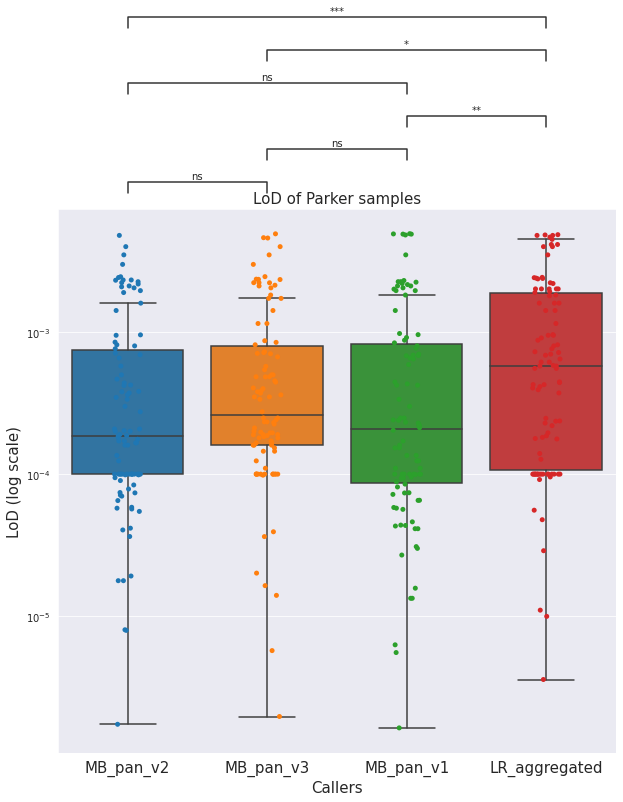

In [52]:
from statannotations.Annotator import Annotator

def boxplot_LoD(df):
    
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10))
    sns.set_style('darkgrid')
    
    # Plotting the boxplot and stripplot with the specified order
    sns.boxplot(data=df, x="Caller_Type", y="LoD", ax=ax0, showfliers=False)
    sns.stripplot(data=df, x="Caller_Type", y="LoD", jitter=True, size=5, ax=ax0)
    
    #log scale
    ax0.set_yscale("log") 
    
    met_sites = df['Caller_Type'].unique()
    pairs = []
    
    for i, met_site in enumerate(met_sites):
        subgroup = df[df['Caller_Type'] == met_site]
        n = subgroup.shape[0]
        
        # Calculate median, CI, and SD
        median = subgroup['LoD'].median()
        sd = subgroup['LoD'].std()
        ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
        print(f'{met_site}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
        
        # Create pairs for statistical annotation
        for other_met_site in met_sites[i+1:]:
            pairs.append((met_site, other_met_site))
    
    # Creating an Annotator object and adding statistical annotation
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD')
    # annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # Setting other plot properties
    plt.title('LoD of Parker samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    plt.show()

boxplot_LoD(df_lod_plot)

Series([], Name: treatment, dtype: int64)
LR_aggregated - on-treatment: Median = 0.00069, SD = 0.00137, CI = (0.00011, 0.00127)
LR_aggregated - post-treatment: Median = 0.00069, SD = 0.00074, CI = (0.00035, 0.00103)
LR_aggregated - pre-treatment: Median = 0.00056, SD = 0.00153, CI = (0.00012, 0.00099)
MB_pan_v1 - on-treatment: Median = 0.00014, SD = 0.00143, CI = (-0.00047, 0.00074)
MB_pan_v1 - post-treatment: Median = 0.00017, SD = 0.00121, CI = (-0.00038, 0.00072)
MB_pan_v1 - pre-treatment: Median = 0.00023, SD = 0.00098, CI = (-0.00005, 0.00051)
MB_pan_v2 - on-treatment: Median = 0.00017, SD = 0.00080, CI = (-0.00017, 0.00051)
MB_pan_v2 - post-treatment: Median = 0.00019, SD = 0.00096, CI = (-0.00025, 0.00062)
MB_pan_v2 - pre-treatment: Median = 0.00020, SD = 0.00105, CI = (-0.00010, 0.00050)
MB_pan_v3 - on-treatment: Median = 0.00024, SD = 0.00134, CI = (-0.00032, 0.00081)
MB_pan_v3 - post-treatment: Median = 0.00037, SD = 0.00126, CI = (-0.00020, 0.00094)
MB_pan_v3 - pre-treatment

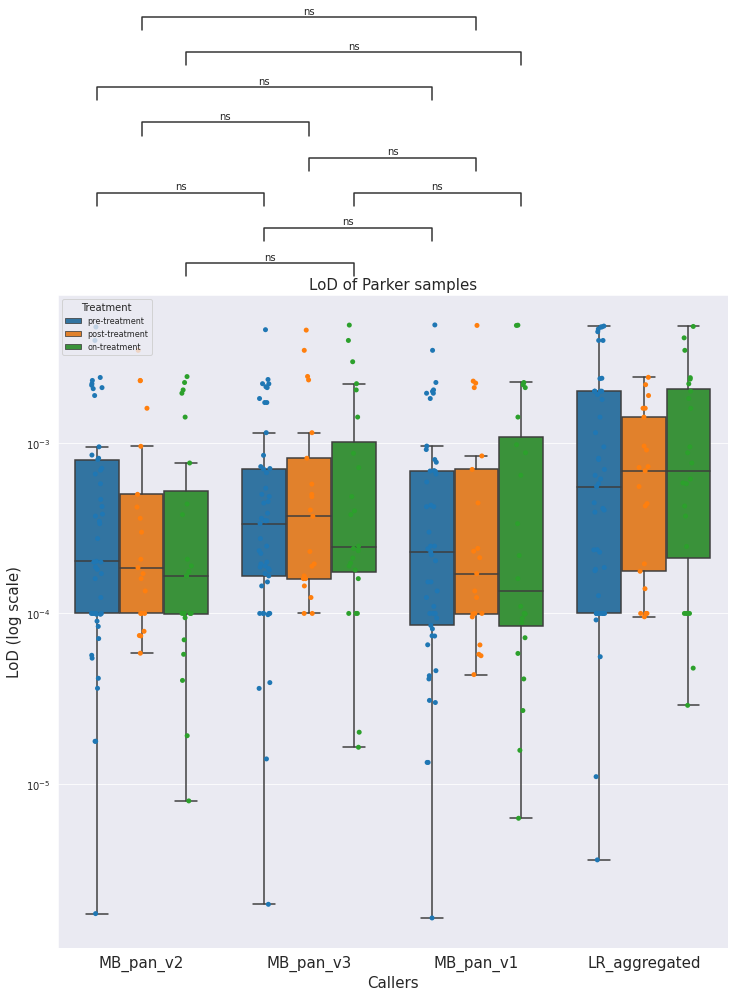

In [53]:
def boxplot_LoD_group(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="treatment", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="treatment", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('treatment')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_pan_v2", "pre-treatment"), ("MB_pan_v1", "pre-treatment")),
        (("MB_pan_v2", "on-treatment"), ("MB_pan_v1", "on-treatment")),
        (("MB_pan_v2", "post-treatment"), ("MB_pan_v1", "post-treatment")),

        (("MB_pan_v3", "pre-treatment"), ("MB_pan_v1", "pre-treatment")),
        (("MB_pan_v3", "on-treatment"), ("MB_pan_v1", "on-treatment")),
        (("MB_pan_v3", "post-treatment"), ("MB_pan_v1", "post-treatment")),

        (("MB_pan_v2", "pre-treatment"), ("MB_pan_v3", "pre-treatment")),
        (("MB_pan_v2", "on-treatment"), ("MB_pan_v3", "on-treatment")),
        (("MB_pan_v2", "post-treatment"), ("MB_pan_v3", "post-treatment")),
    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='treatment')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of Parker samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:3], labels[0:3], title='Treatment', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

df_lod_plot_treat = df_lod_plot[df_lod_plot["treatment"] != "uncertain"]
print(df_lod_plot_treat[df_lod_plot_treat["Caller_Type"] == "MB_pan"].treatment.value_counts())
boxplot_LoD_group(df_lod_plot_treat)

LR_aggregated - Bladder cancer: Median = 0.00072, SD = 0.00076, CI = (0.00014, 0.00130)
LR_aggregated - Breast cancer: Median = 0.00039, SD = 0.00075, CI = (-0.00054, 0.00132)
LR_aggregated - Colon cancer: Median = 0.00062, SD = 0.00060, CI = (0.00006, 0.00117)
LR_aggregated - Gastroesophageal cancer: Median = 0.00010, SD = 0.00185, CI = (-0.00161, 0.00181)
LR_aggregated - Prostate cancer: Median = 0.00018, SD = 0.00181, CI = (-0.00207, 0.00242)
LR_aggregated - Small cell lung cancer: Median = 0.00059, SD = 0.00076, CI = (-0.00022, 0.00139)
LR_aggregated - other: Median = 0.00076, SD = 0.00150, CI = (0.00037, 0.00115)
MB_pan_v1 - Bladder cancer: Median = 0.00034, SD = 0.00080, CI = (-0.00028, 0.00095)
MB_pan_v1 - Breast cancer: Median = 0.00016, SD = 0.00026, CI = (-0.00017, 0.00049)
MB_pan_v1 - Colon cancer: Median = 0.00006, SD = 0.00004, CI = (0.00002, 0.00010)
MB_pan_v1 - Gastroesophageal cancer: Median = 0.00010, SD = 0.00011, CI = (-0.00000, 0.00020)
MB_pan_v1 - Prostate cancer: 

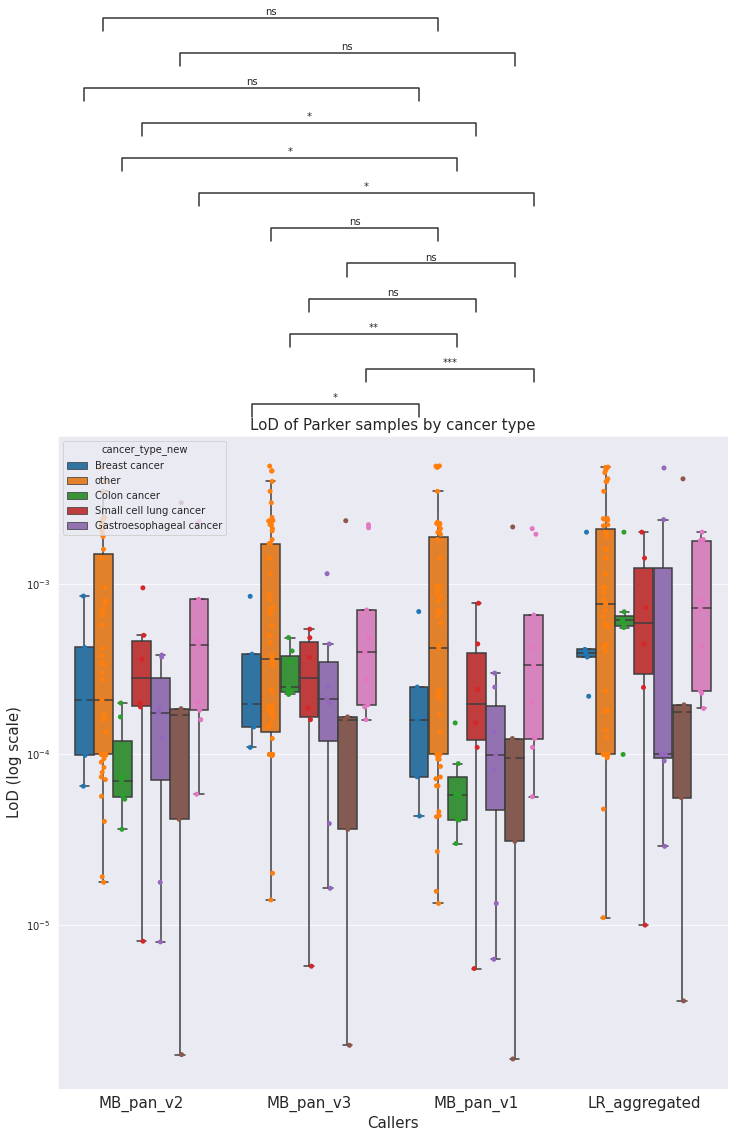

In [55]:
def boxplot_LoD_cancer_parker(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type_new", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type_new", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('cancer_type_new')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_pan_v1", "Bladder cancer"), ("MB_pan_v2", "Bladder cancer")),
        (("MB_pan_v1", "Colon cancer"), ("MB_pan_v2", "Colon cancer")),
        (("MB_pan_v1", "Small cell lung cancer"), ("MB_pan_v2", "Small cell lung cancer")),
        (("MB_pan_v1", "Breast cancer"), ("MB_pan_v2", "Breast cancer")),
        (("MB_pan_v1", "Prostate cancer"), ("MB_pan_v2", "Prostate cancer")),
        (("MB_pan_v1", "other"), ("MB_pan_v2", "other")),
    
        (("MB_pan_v1", "Bladder cancer"), ("MB_pan_v3", "Bladder cancer")),
        (("MB_pan_v1", "Colon cancer"), ("MB_pan_v3", "Colon cancer")),
        (("MB_pan_v1", "Small cell lung cancer"), ("MB_pan_v3", "Small cell lung cancer")),
        (("MB_pan_v1", "Breast cancer"), ("MB_pan_v3", "Breast cancer")),
        (("MB_pan_v1", "Prostate cancer"), ("MB_pan_v3", "Prostate cancer")),
        (("MB_pan_v1", "other"), ("MB_pan_v3", "other")),
    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='cancer_type_new')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of Parker samples by cancer type', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:5], labels[0:5], title='cancer_type_new', loc='upper left', fontsize = 10)  # Adjust depending on your number of categories

    plt.show()

# df_lod_cancer = df_lod_plot[(df_lod_plot["cancer_type"] == "Bladder cancer") | (df_lod_plot["cancer_type"] == "Colon cancer") | (df_lod_plot["cancer_type"] == "Small cell lung cancer") | (df_lod_plot["cancer_type"] == "Breast cancer") | (df_lod_plot["cancer_type"] == "Prostate cancer")]
boxplot_LoD_cancer_parker(df_lod_plot)

Bladder cancer - LR_aggregated: Median = 0.00072, SD = 0.00076, CI = (0.00014, 0.00130)
Bladder cancer - MB_pan_v1: Median = 0.00034, SD = 0.00080, CI = (-0.00028, 0.00095)
Bladder cancer - MB_pan_v2: Median = 0.00044, SD = 0.00090, CI = (-0.00025, 0.00113)
Bladder cancer - MB_pan_v3: Median = 0.00040, SD = 0.00083, CI = (-0.00024, 0.00104)
Breast cancer - LR_aggregated: Median = 0.00039, SD = 0.00075, CI = (-0.00054, 0.00132)
Breast cancer - MB_pan_v1: Median = 0.00016, SD = 0.00026, CI = (-0.00017, 0.00049)
Breast cancer - MB_pan_v2: Median = 0.00021, SD = 0.00032, CI = (-0.00019, 0.00061)
Breast cancer - MB_pan_v3: Median = 0.00020, SD = 0.00030, CI = (-0.00018, 0.00058)
Colon cancer - LR_aggregated: Median = 0.00062, SD = 0.00060, CI = (0.00006, 0.00117)
Colon cancer - MB_pan_v1: Median = 0.00006, SD = 0.00004, CI = (0.00002, 0.00010)
Colon cancer - MB_pan_v2: Median = 0.00007, SD = 0.00006, CI = (0.00001, 0.00013)
Colon cancer - MB_pan_v3: Median = 0.00025, SD = 0.00010, CI = (0.0

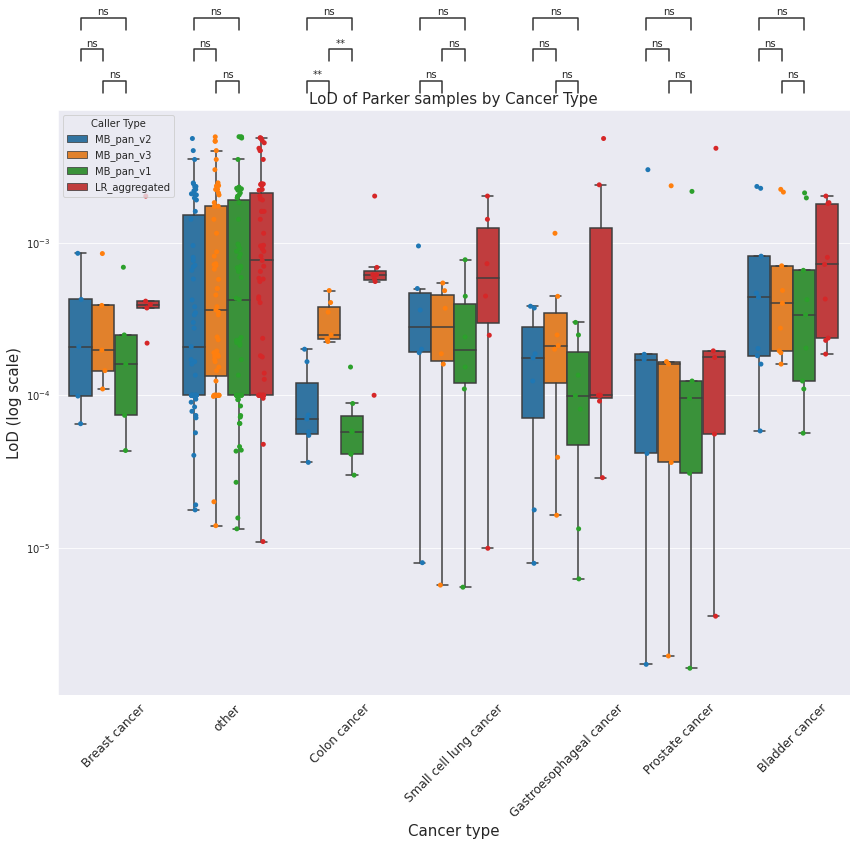

In [75]:
def boxplot_LoD_cancer_parker_new(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="cancer_type_new", y="LoD", hue="Caller_Type", ax=ax0, palette=palette, showfliers=False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="cancer_type_new", y="LoD", hue="Caller_Type", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log")
    
    # Adjusting for statistics
    for cancer_type, group in df.groupby('cancer_type_new'):
        for caller_type, subgroup in group.groupby('Caller_Type'):
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup)-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{cancer_type} - {caller_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    # Defining new pairs for within cancer type caller comparison
    cancer_types = df['cancer_type_new'].unique()
    caller_types = ["MB_pan_v1", "MB_pan_v2", "MB_pan_v3"]
    
    pairs = []
    for cancer_type in cancer_types:
        for i in range(len(caller_types)):
            for j in range(i+1, len(caller_types)):
                pairs.append(((cancer_type, caller_types[i]), (cancer_type, caller_types[j])))
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='cancer_type_new', y='LoD', hue='Caller_Type')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of Parker samples by Cancer Type', fontsize=15)
    ax0.set_xlabel('Cancer type', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, fontsize=12)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    # Assuming the first few handles and labels are for the cancer types; adjust as necessary
    ax0.legend(unique_handles[:len(caller_types) + 1], unique_labels[:len(caller_types) + 1], title='Caller Type', loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()

boxplot_LoD_cancer_parker_new(df_lod_plot)

In [57]:
# Filter the DataFrame for pre-treatment and the two caller types
pre_treatment_data = df_lod_plot_treat[df_lod_plot_treat['treatment'] == 'on-treatment']
pan_eclipseIA_data = pre_treatment_data[pre_treatment_data['Caller_Type'] == 'MB_pan_v2']
pan_data = pre_treatment_data[pre_treatment_data['Caller_Type'] == 'MB_pan_v1']

# Ensure the data is sorted by 'run_sample_id' so that the pairs match
pan_eclipseIA_data = pan_eclipseIA_data.sort_values('run_sample_id')
pan_data = pan_data.sort_values('run_sample_id')

# Perform the paired t-test on matched pairs
# We use 'merge' to make sure we only compare the same 'run_sample_id'
merged_data = pd.merge(pan_eclipseIA_data, pan_data, on='run_sample_id', suffixes=('_pan_v2', '_pan_v1'))
t_stat, p_val = stats.ttest_rel(merged_data['LoD_pan_v2'], merged_data['LoD_pan_v1'])

print(f'T-statistic: {t_stat}, P-value: {p_val}')


T-statistic: -1.1668081200379372, P-value: 0.2552436240129189


### MRD AV samples

In [58]:
#merge all LoDs of different callers of MRD AV LoQ samples
df_lod_pan_loq = pd.read_table(f"{work_dir}/MRD_AV_LoQ_mb_pan_interpolation_LoD.tsv")
df_lod_pan_eclipseIA_loq = pd.read_table(f"{work_dir}/MRD_AV_LoQ_mb_pan_eclipseIA_interpolation_LoD.tsv")
df_lod_pan_lessCRC_loq = pd.read_table(f"{work_dir}/MRD_AV_LoQ_mb_pan_lessCRC_interpolation_LoD.tsv")
df_lod_lr_agg_loq = pd.read_table(f"{work_dir}/MRD_AV_LoQ_lr_aggregated_interpolation_LoD.tsv")

# Merge the dataframes on 'run_sample_id'
df_merged = pd.merge(df_lod_pan_eclipseIA_loq, df_lod_pan_loq[['run_sample_id', 'LoD']], on="run_sample_id", how='inner', suffixes=('_eclipseIA', '_pan'))
df_lod_merged = pd.merge(df_merged, df_lod_lr_agg_loq[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod_merged.rename(columns={'LoD': 'LoD_lr_agg'}, inplace=True)
df_lod_loq = pd.merge(df_lod_merged, df_lod_pan_lessCRC_loq[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod_loq.rename(columns={'LoD': 'LoD_lessCRC'}, inplace=True)


#melt data for LoD visulization
df_lod_loq_plot = pd.melt(df_lod_loq, id_vars=['run_sample_id', 'cancer_type', 'input'],
                      value_vars=['LoD_eclipseIA', 'LoD_lessCRC', 'LoD_pan', 'LoD_lr_agg'], 
                      var_name='Caller_Type', value_name='LoD')

df_lod_loq_plot['Caller_Type'] = df_lod_loq_plot['Caller_Type'].replace({'LoD_pan': 'MB_pan_v1', 'LoD_eclipseIA': 'MB_pan_v2', 'LoD_lessCRC': 'MB_pan_v3', 'LoD_lr_agg': 'LR_aggregated'})
print(df_lod_pan_loq.cancer_type.value_counts())
df_lod_loq_plot.head()

PA        41
PR        41
CRC       18
LUNG      18
BREAST    18
Name: cancer_type, dtype: int64


,run_sample_id,cancer_type,input,Caller_Type,LoD
0,KM12_20_15_R1,CRC,15,MB_pan_v2,0.000038
1,H1648_20_15_R1,LUNG,15,MB_pan_v2,0.000275
2,H2218_20_15_R3,BREAST,15,MB_pan_v2,0.000096
3,H2218_20_15_R2,BREAST,15,MB_pan_v2,0.000110
4,H1648_20_15_R2,LUNG,15,MB_pan_v2,0.000241


In [59]:
#merge all LoDs of different callers of MRD AV Accuracy samples
df_lod_pan_acc = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_mb_pan_interpolation_LoD.tsv")
df_lod_pan_eclipseIA_acc = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_mb_pan_eclipseIA_interpolation_LoD.tsv")
df_lod_pan_lessCRC_acc = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_mb_pan_lessCRC_interpolation_LoD.tsv")
df_lod_lr_agg_acc = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_lr_aggregated_interpolation_LoD.tsv")

# Merge the dataframes on 'run_sample_id'
df_merged = pd.merge(df_lod_pan_eclipseIA_acc, df_lod_pan_acc[['run_sample_id', 'LoD']], on="run_sample_id", how='inner', suffixes=('_eclipseIA', '_pan'))
df_lod_merged = pd.merge(df_merged, df_lod_lr_agg_acc[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod_merged.rename(columns={'LoD': 'LoD_lr_agg'}, inplace=True)
df_lod_acc = pd.merge(df_lod_merged, df_lod_pan_lessCRC_acc[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod_acc.rename(columns={'LoD': 'LoD_lessCRC'}, inplace=True)

#melt data for LoD visulization
df_lod_acc_plot = pd.melt(df_lod_acc, id_vars=['run_sample_id', 'cancer_type'],
                      value_vars=['LoD_eclipseIA', 'LoD_lessCRC', 'LoD_pan', 'LoD_lr_agg'], 
                      var_name='Caller_Type', value_name='LoD')

df_lod_acc_plot['Caller_Type'] = df_lod_acc_plot['Caller_Type'].replace({'LoD_pan': 'MB_pan_v1', 'LoD_eclipseIA': 'MB_pan_v2', 'LoD_lessCRC': 'MB_pan_v3', 'LoD_lr_agg': 'LR_aggregated'})
print(df_lod_pan_acc.cancer_type.value_counts())
df_lod_acc_plot.head()

Lung adenocarcinoma                 26
Breast Carcinoma                    20
Colorectal adenocarcinoma           19
other                               17
Pancreatic ductal adenocarcinoma    13
Prostate adenocarcinoma              9
Gastric adenocarcinoma               2
Name: cancer_type, dtype: int64


,run_sample_id,cancer_type,Caller_Type,LoD
0,Accu_HRD10_4507,Colorectal adenocarcinoma,MB_pan_v2,0.000210
1,Accu_HRD3_4608,Colorectal adenocarcinoma,MB_pan_v2,0.000166
2,Accu_HRD6_4405,Breast Carcinoma,MB_pan_v2,0.000500
3,CA_298572,Pancreatic ductal adenocarcinoma,MB_pan_v2,0.000458
4,CA_302203,Breast Carcinoma,MB_pan_v2,0.000204


MB_pan_v2: Median = 0.00037, SD = 0.00089, CI = (0.00020, 0.00054)
MB_pan_v3: Median = 0.00047, SD = 0.00103, CI = (0.00027, 0.00067)
MB_pan_v1: Median = 0.00023, SD = 0.00075, CI = (0.00008, 0.00037)
LR_aggregated: Median = 0.00066, SD = 0.00119, CI = (0.00043, 0.00089)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_pan_v2 vs. MB_pan_v3: t-test paired samples, P_val:2.211e-03 t=-3.138e+00
MB_pan_v3 vs. MB_pan_v1: t-test paired samples, P_val:4.412e-06 t=4.844e+00
MB_pan_v1 vs. LR_aggregated: t-test paired samples, P_val:4.341e-07 t=-5.391e+00
MB_pan_v2 vs. MB_pan_v1: t-test paired samples, P_val:2.390e-10 t=7.009e+00
MB_pan_v3 vs. LR_aggregated: t-test paired samples, P_val:3.888e-02 t=-2.092e+00
MB_pan_v2 vs. LR_aggregated: t-test paired samples, P_val:8.414e-05 t=-4.092e+00


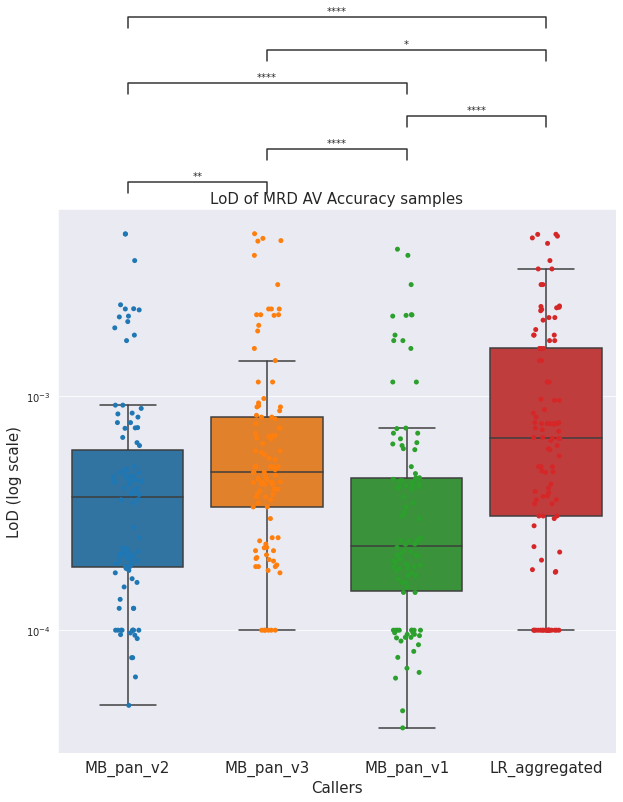

In [80]:
from statannotations.Annotator import Annotator

def boxplot_LoD_mrd(df):
    
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10))
    sns.set_style('darkgrid')
    
    # Plotting the boxplot and stripplot with the specified order
    sns.boxplot(data=df, x="Caller_Type", y="LoD", ax=ax0, showfliers=False)
    sns.stripplot(data=df, x="Caller_Type", y="LoD", jitter=True, size=5, ax=ax0)
    
    #log scale
    ax0.set_yscale("log") 
    
    met_sites = df['Caller_Type'].unique()
    pairs = []
    
    for i, met_site in enumerate(met_sites):
        subgroup = df[df['Caller_Type'] == met_site]
        n = subgroup.shape[0]
        
        # Calculate median, CI, and SD
        median = subgroup['LoD'].median()
        sd = subgroup['LoD'].std()
        ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
        print(f'{met_site}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
        
        # Create pairs for statistical annotation
        for other_met_site in met_sites[i+1:]:
            pairs.append((met_site, other_met_site))
    
    # Creating an Annotator object and adding statistical annotation
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD')
    # annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # Setting other plot properties
    plt.title('LoD of MRD AV Accuracy samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    plt.show()

# visulize the LoD 
# boxplot_LoD_mrd(df_lod_loq_plot)
boxplot_LoD_mrd(df_lod_acc_plot)

MB_pan_v2: Median = 0.00023, SD = 0.00009, CI = (0.00020, 0.00026)
MB_pan_v3: Median = 0.00022, SD = 0.00006, CI = (0.00020, 0.00024)
MB_pan_v1: Median = 0.00019, SD = 0.00006, CI = (0.00017, 0.00021)
LR_aggregated: Median = 0.00047, SD = 0.00019, CI = (0.00040, 0.00053)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_pan_v2 vs. MB_pan_v3: t-test paired samples, P_val:9.281e-01 t=-9.084e-02
MB_pan_v3 vs. MB_pan_v1: t-test paired samples, P_val:2.328e-08 t=7.167e+00
MB_pan_v1 vs. LR_aggregated: t-test paired samples, P_val:2.615e-10 t=-8.730e+00
MB_pan_v2 vs. MB_pan_v1: t-test paired samples, P_val:1.534e-07 t=6.535e+00
MB_pan_v3 vs. LR_aggregated: t-test paired samples, P_val:2.726e-09 t=-7.902e+00
MB_pan_v2 vs. LR_aggregated: t-test paired samples, P_val:5.477e-08 t=-6.879e+00


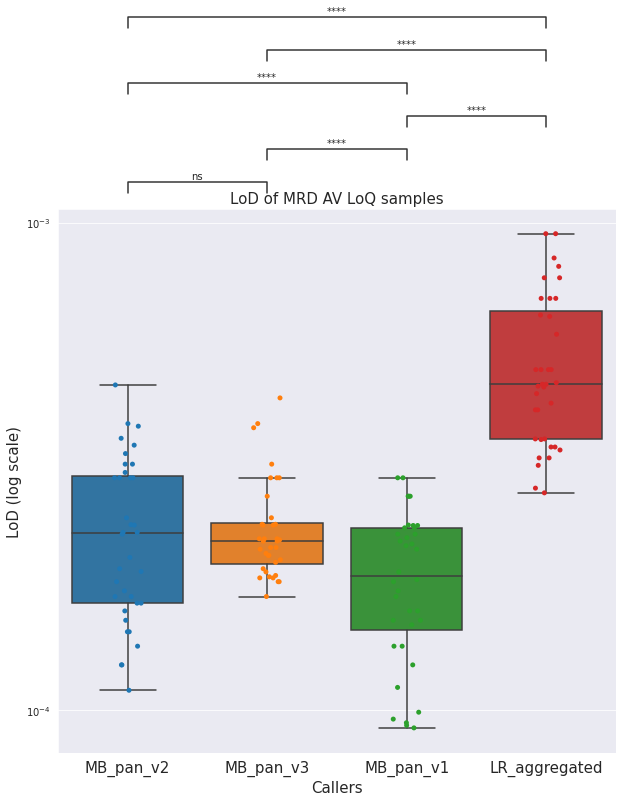

(144, 5)
MB_pan_v2: Median = 0.00012, SD = 0.00007, CI = (0.00010, 0.00013)
MB_pan_v3: Median = 0.00019, SD = 0.00006, CI = (0.00018, 0.00020)
MB_pan_v1: Median = 0.00009, SD = 0.00006, CI = (0.00008, 0.00010)
LR_aggregated: Median = 0.00022, SD = 0.00008, CI = (0.00020, 0.00023)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_pan_v2 vs. MB_pan_v3: t-test paired samples, P_val:1.301e-07 t=-5.689e+00
MB_pan_v3 vs. MB_pan_v1: t-test paired samples, P_val:1.386e-17 t=1.041e+01
MB_pan_v1 vs. LR_aggregated: t-test paired samples, P_val:4.246e-23 t=-1.298e+01
MB_pan_v2 vs. MB_pan_v1: t-test paired samples, P_val:2.245e-24 t=1.360e+01
MB_pan_v3 vs. LR_aggregated: t-test paired samples, P_val:6.828e-10 t=-6.834e+00
MB_pan_v2 vs. LR_aggregated: t-test paired samples, P_val:7.131e-16 t=-9.627e+00


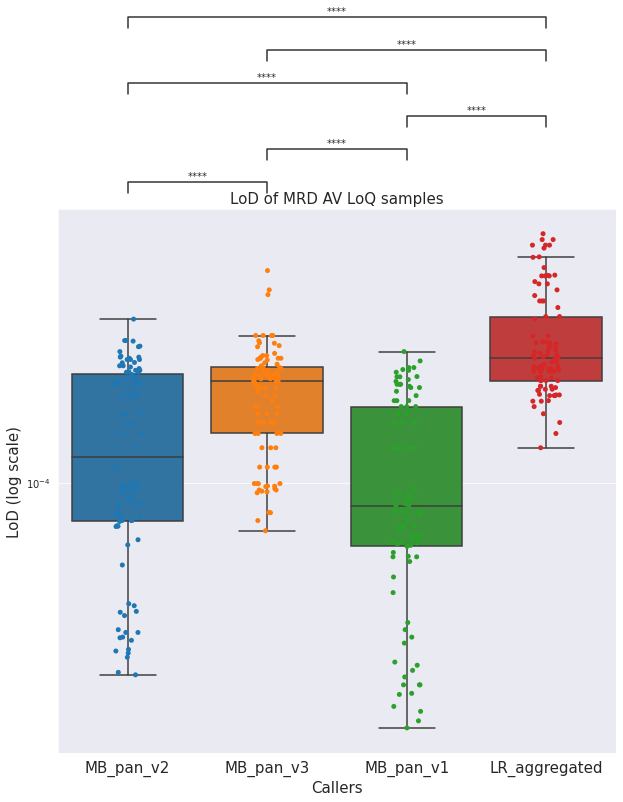

(400, 5)


In [68]:
df_5 = df_lod_loq_plot[df_lod_loq_plot["input"] == 5]
boxplot_LoD_mrd(df_5)
print(df_5.shape)
df_15 = df_lod_loq_plot[df_lod_loq_plot["input"] == 15]
boxplot_LoD_mrd(df_15)
print(df_15.shape)


LR_aggregated - 5: Median = 0.00047, SD = 0.00019, CI = (0.00040, 0.00053)
LR_aggregated - 15: Median = 0.00022, SD = 0.00008, CI = (0.00020, 0.00023)
MB_pan_v1 - 5: Median = 0.00019, SD = 0.00006, CI = (0.00017, 0.00021)
MB_pan_v1 - 15: Median = 0.00009, SD = 0.00006, CI = (0.00008, 0.00010)
MB_pan_v2 - 5: Median = 0.00023, SD = 0.00009, CI = (0.00020, 0.00026)
MB_pan_v2 - 15: Median = 0.00012, SD = 0.00007, CI = (0.00010, 0.00013)
MB_pan_v3 - 5: Median = 0.00022, SD = 0.00006, CI = (0.00020, 0.00024)
MB_pan_v3 - 15: Median = 0.00019, SD = 0.00006, CI = (0.00018, 0.00020)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_pan_v2_15 vs. MB_pan_v3_15: t-test independent samples, P_val:2.540e-06 t=-4.846e+00
MB_pan_v3_5 vs. MB_pan_v1_5: t-test independent samples, P_val:1.267e-03 t=3.359e+00
MB_pan_v2_5 vs. MB_pan_v3_5: t-test independent samples, P_val:9.6

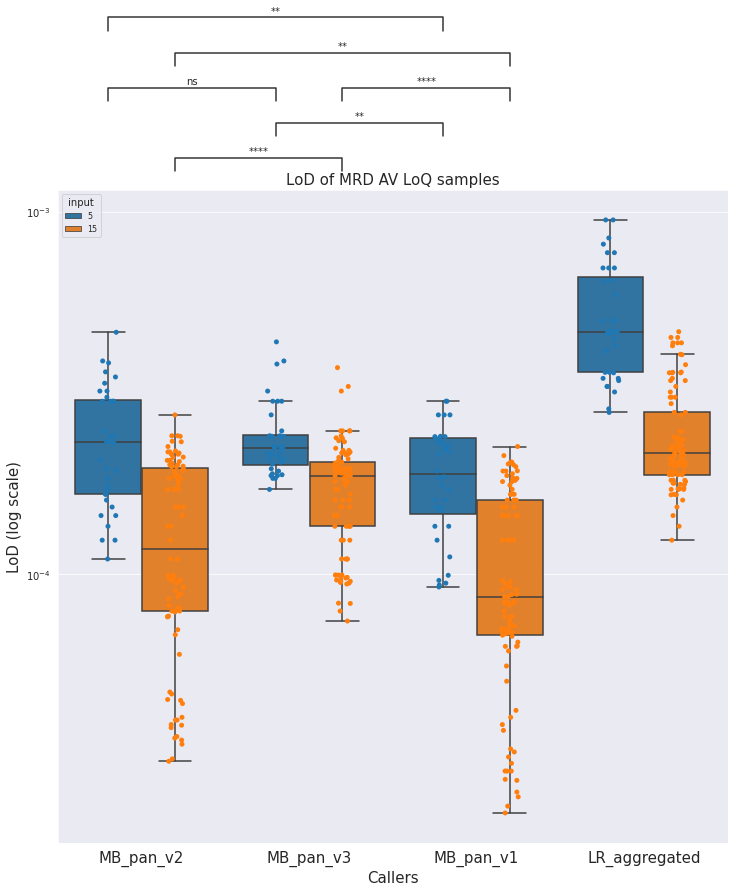

In [69]:
def boxplot_LoD_input(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="input", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="input", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('input')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
  
    pairs = [
        (("MB_pan_v1", 15), ("MB_pan_v2", 15)),
        (("MB_pan_v1", 15), ("MB_pan_v3", 15)),
        (("MB_pan_v2", 15), ("MB_pan_v3", 15)),
        (("MB_pan_v1", 5), ("MB_pan_v2", 5)),
        (("MB_pan_v1", 5), ("MB_pan_v3", 5)),
        (("MB_pan_v2", 5), ("MB_pan_v3", 5)),
    ]
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='input')
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of MRD AV LoQ samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:2], labels[0:2], title='input', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

boxplot_LoD_input(df_lod_loq_plot)

LR_aggregated - BREAST: Median = 0.00017, SD = 0.00002, CI = (0.00016, 0.00018)
LR_aggregated - CRC: Median = 0.00022, SD = 0.00003, CI = (0.00020, 0.00024)
LR_aggregated - LUNG: Median = 0.00021, SD = 0.00005, CI = (0.00018, 0.00023)
LR_aggregated - PA: Median = 0.00045, SD = 0.00019, CI = (0.00039, 0.00051)
LR_aggregated - PR: Median = 0.00024, SD = 0.00010, CI = (0.00021, 0.00027)
MB_pan_v1 - BREAST: Median = 0.00008, SD = 0.00001, CI = (0.00008, 0.00009)
MB_pan_v1 - CRC: Median = 0.00003, SD = 0.00001, CI = (0.00003, 0.00003)
MB_pan_v1 - LUNG: Median = 0.00016, SD = 0.00003, CI = (0.00014, 0.00017)
MB_pan_v1 - PA: Median = 0.00009, SD = 0.00004, CI = (0.00007, 0.00010)
MB_pan_v1 - PR: Median = 0.00019, SD = 0.00005, CI = (0.00018, 0.00021)
MB_pan_v2 - BREAST: Median = 0.00010, SD = 0.00003, CI = (0.00009, 0.00012)
MB_pan_v2 - CRC: Median = 0.00004, SD = 0.00001, CI = (0.00004, 0.00004)
MB_pan_v2 - LUNG: Median = 0.00019, SD = 0.00003, CI = (0.00018, 0.00021)
MB_pan_v2 - PA: Median 

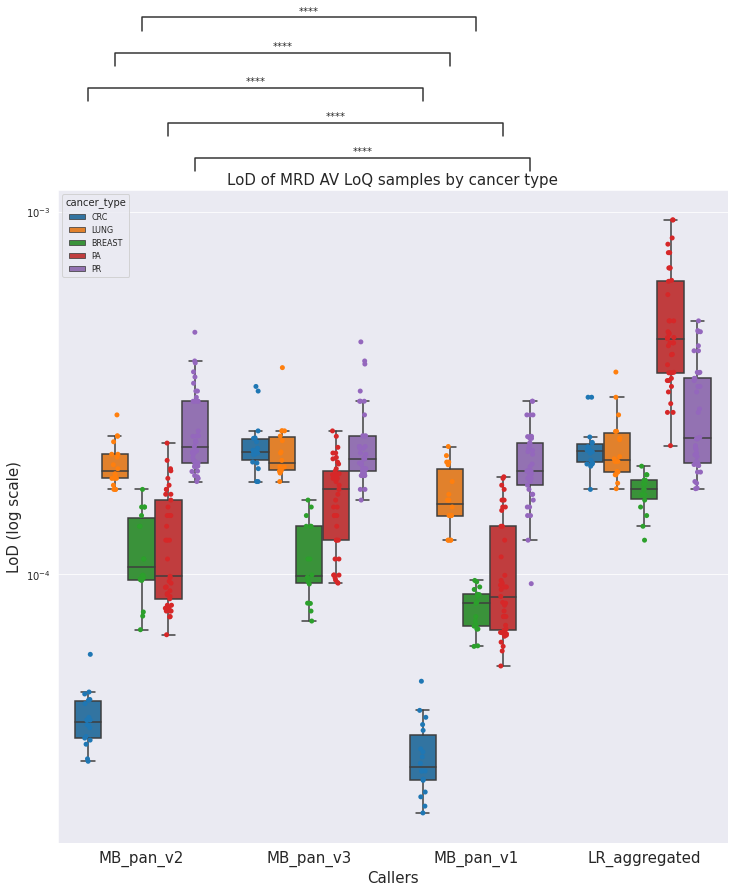

In [65]:
def boxplot_LoD_cancer(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('cancer_type')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_pan_v2", "PA"), ("MB_pan_v1", "PA")),
        (("MB_pan_v2", "PR"), ("MB_pan_v1", "PR")),
        (("MB_pan_v2", "CRC"), ("MB_pan_v1", "CRC")),
        (("MB_pan_v2", "LUNG"), ("MB_pan_v1", "LUNG")),
        (("MB_pan_v2", "BREAST"), ("MB_pan_v1", "BREAST")),

    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='cancer_type')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of MRD AV LoQ samples by cancer type', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:5], labels[0:5], title='cancer_type', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

boxplot_LoD_cancer(df_lod_loq_plot)

BREAST - LR_aggregated: Median = 0.00017, SD = 0.00002, CI = (0.00016, 0.00018)
BREAST - MB_pan_v1: Median = 0.00008, SD = 0.00001, CI = (0.00008, 0.00009)
BREAST - MB_pan_v2: Median = 0.00010, SD = 0.00003, CI = (0.00009, 0.00012)
BREAST - MB_pan_v3: Median = 0.00010, SD = 0.00003, CI = (0.00009, 0.00011)
CRC - LR_aggregated: Median = 0.00022, SD = 0.00003, CI = (0.00020, 0.00024)
CRC - MB_pan_v1: Median = 0.00003, SD = 0.00001, CI = (0.00003, 0.00003)
CRC - MB_pan_v2: Median = 0.00004, SD = 0.00001, CI = (0.00004, 0.00004)
CRC - MB_pan_v3: Median = 0.00022, SD = 0.00004, CI = (0.00020, 0.00024)
LUNG - LR_aggregated: Median = 0.00021, SD = 0.00005, CI = (0.00018, 0.00023)
LUNG - MB_pan_v1: Median = 0.00016, SD = 0.00003, CI = (0.00014, 0.00017)
LUNG - MB_pan_v2: Median = 0.00019, SD = 0.00003, CI = (0.00018, 0.00021)
LUNG - MB_pan_v3: Median = 0.00020, SD = 0.00004, CI = (0.00018, 0.00022)
PA - LR_aggregated: Median = 0.00045, SD = 0.00019, CI = (0.00039, 0.00051)
PA - MB_pan_v1: Medi

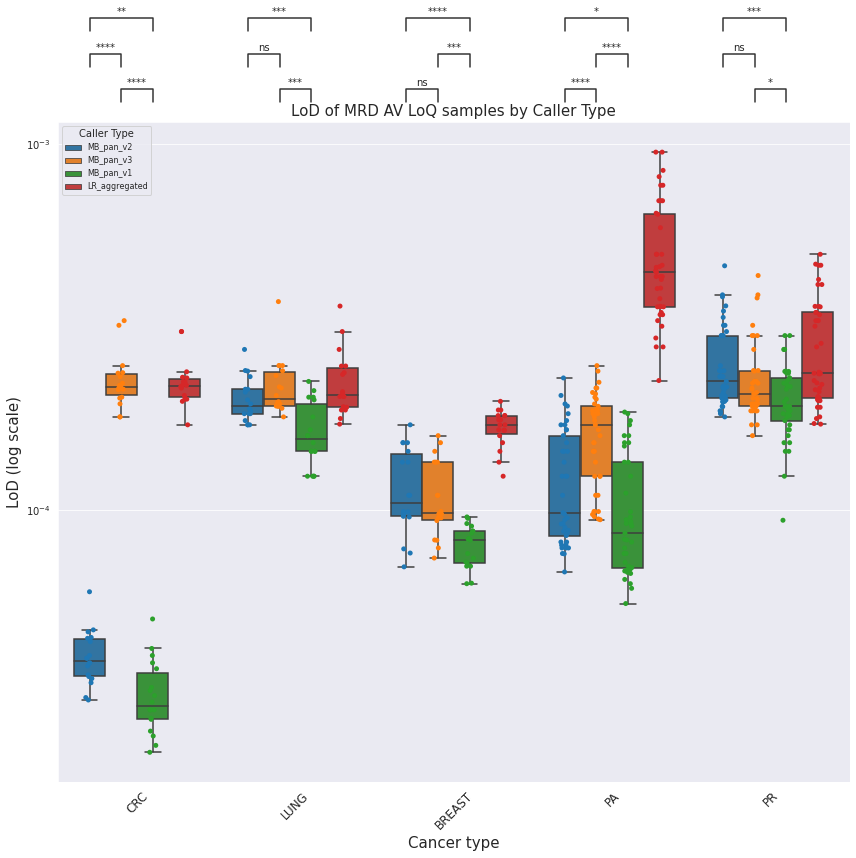

In [76]:
def boxplot_LoD_cancer_new(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="cancer_type", y="LoD", hue="Caller_Type", ax=ax0, palette=palette, showfliers=False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="cancer_type", y="LoD", hue="Caller_Type", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log")
    
    # Adjusting for statistics
    for cancer_type, group in df.groupby('cancer_type'):
        for caller_type, subgroup in group.groupby('Caller_Type'):
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup)-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{cancer_type} - {caller_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    # Adjusting pairs for within cancer type caller comparison
    cancer_types = df['cancer_type'].unique()
    caller_types = ["MB_pan_v1", "MB_pan_v2", "MB_pan_v3"]  
    
    pairs = []
    for cancer_type in cancer_types:
        for i in range(len(caller_types) - 1):
            for j in range(i + 1, len(caller_types)):
                pairs.append(((cancer_type, caller_types[i]), (cancer_type, caller_types[j])))
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='cancer_type', y='LoD', hue='Caller_Type')
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of MRD AV LoQ samples by Caller Type', fontsize=15)
    ax0.set_xlabel('Cancer type', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, fontsize=12)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    # Adjusting legend to display only a subset for clarity
    ax0.legend(unique_handles[:len(caller_types) + 1], unique_labels[:len(caller_types) + 1], title='Caller Type', loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

boxplot_LoD_cancer_new(df_lod_loq_plot)

LR_aggregated - Breast Carcinoma: Median = 0.00038, SD = 0.00020, CI = (0.00029, 0.00048)
LR_aggregated - Colorectal adenocarcinoma: Median = 0.00076, SD = 0.00070, CI = (0.00043, 0.00110)
LR_aggregated - Gastric adenocarcinoma: Median = 0.00199, SD = 0.00056, CI = (-0.00301, 0.00700)
LR_aggregated - Lung adenocarcinoma: Median = 0.00120, SD = 0.00167, CI = (0.00052, 0.00187)
LR_aggregated - Pancreatic ductal adenocarcinoma: Median = 0.00066, SD = 0.00153, CI = (-0.00027, 0.00159)
LR_aggregated - Prostate adenocarcinoma: Median = 0.00050, SD = 0.00020, CI = (0.00035, 0.00065)
LR_aggregated - other: Median = 0.00076, SD = 0.00098, CI = (0.00026, 0.00127)
MB_pan_v1 - Breast Carcinoma: Median = 0.00032, SD = 0.00016, CI = (0.00025, 0.00040)
MB_pan_v1 - Colorectal adenocarcinoma: Median = 0.00015, SD = 0.00026, CI = (0.00003, 0.00028)
MB_pan_v1 - Gastric adenocarcinoma: Median = 0.00012, SD = 0.00009, CI = (-0.00065, 0.00089)
MB_pan_v1 - Lung adenocarcinoma: Median = 0.00042, SD = 0.00123,

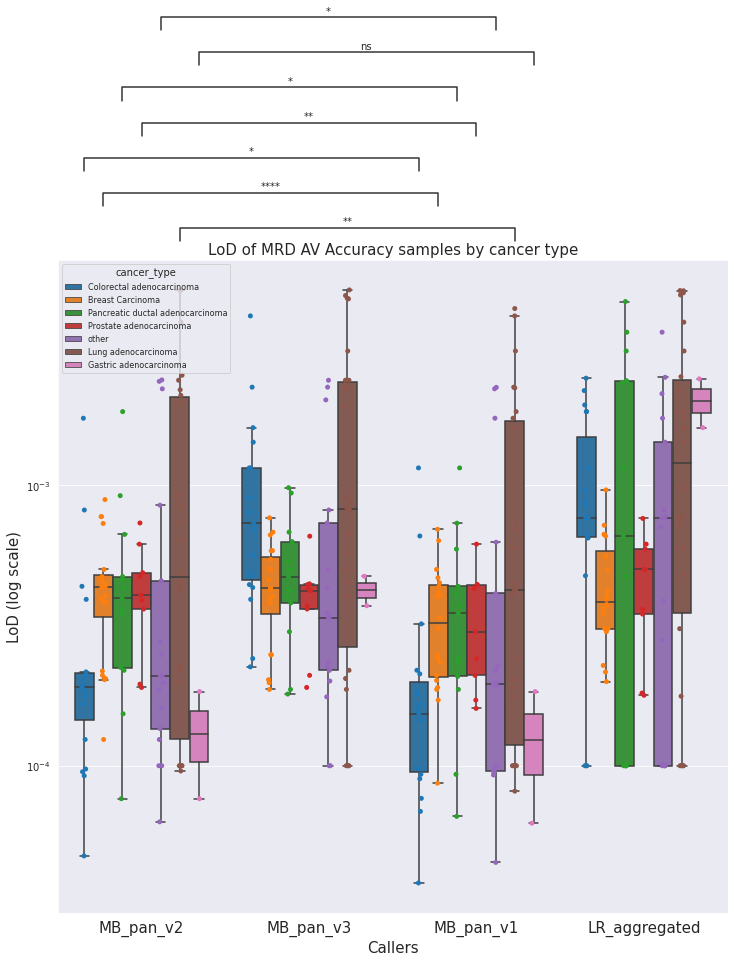

In [66]:
def boxplot_LoD_cancer_acc(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('cancer_type')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_pan_v2", "Lung adenocarcinoma"), ("MB_pan_v1", "Lung adenocarcinoma")),
        (("MB_pan_v2", "Breast Carcinoma"), ("MB_pan_v1", "Breast Carcinoma")),
        (("MB_pan_v2", "Colorectal adenocarcinoma"), ("MB_pan_v1", "Colorectal adenocarcinoma")),
        (("MB_pan_v2", "Prostate adenocarcinoma"), ("MB_pan_v1", "Prostate adenocarcinoma")),
        (("MB_pan_v2", "Pancreatic ductal adenocarcinoma"), ("MB_pan_v1", "Pancreatic ductal adenocarcinoma")),
        (("MB_pan_v2", "Gastric adenocarcinoma"), ("MB_pan_v1", "Gastric adenocarcinoma")),
        (("MB_pan_v2", "other"), ("MB_pan_v1", "other")),
    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='cancer_type')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of MRD AV Accuracy samples by cancer type', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:7], labels[0:7], title='cancer_type', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

boxplot_LoD_cancer_acc(df_lod_acc_plot)

Breast Carcinoma - LR_aggregated: Median = 0.00038, SD = 0.00020, CI = (0.00029, 0.00048)
Breast Carcinoma - MB_pan_v1: Median = 0.00032, SD = 0.00016, CI = (0.00025, 0.00040)
Breast Carcinoma - MB_pan_v2: Median = 0.00043, SD = 0.00021, CI = (0.00034, 0.00053)
Breast Carcinoma - MB_pan_v3: Median = 0.00043, SD = 0.00017, CI = (0.00035, 0.00051)
Colorectal adenocarcinoma - LR_aggregated: Median = 0.00076, SD = 0.00070, CI = (0.00043, 0.00110)
Colorectal adenocarcinoma - MB_pan_v1: Median = 0.00015, SD = 0.00026, CI = (0.00003, 0.00028)
Colorectal adenocarcinoma - MB_pan_v2: Median = 0.00019, SD = 0.00039, CI = (0.00000, 0.00038)
Colorectal adenocarcinoma - MB_pan_v3: Median = 0.00073, SD = 0.00089, CI = (0.00030, 0.00116)
Gastric adenocarcinoma - LR_aggregated: Median = 0.00199, SD = 0.00056, CI = (-0.00301, 0.00700)
Gastric adenocarcinoma - MB_pan_v1: Median = 0.00012, SD = 0.00009, CI = (-0.00065, 0.00089)
Gastric adenocarcinoma - MB_pan_v2: Median = 0.00013, SD = 0.00008, CI = (-0.0

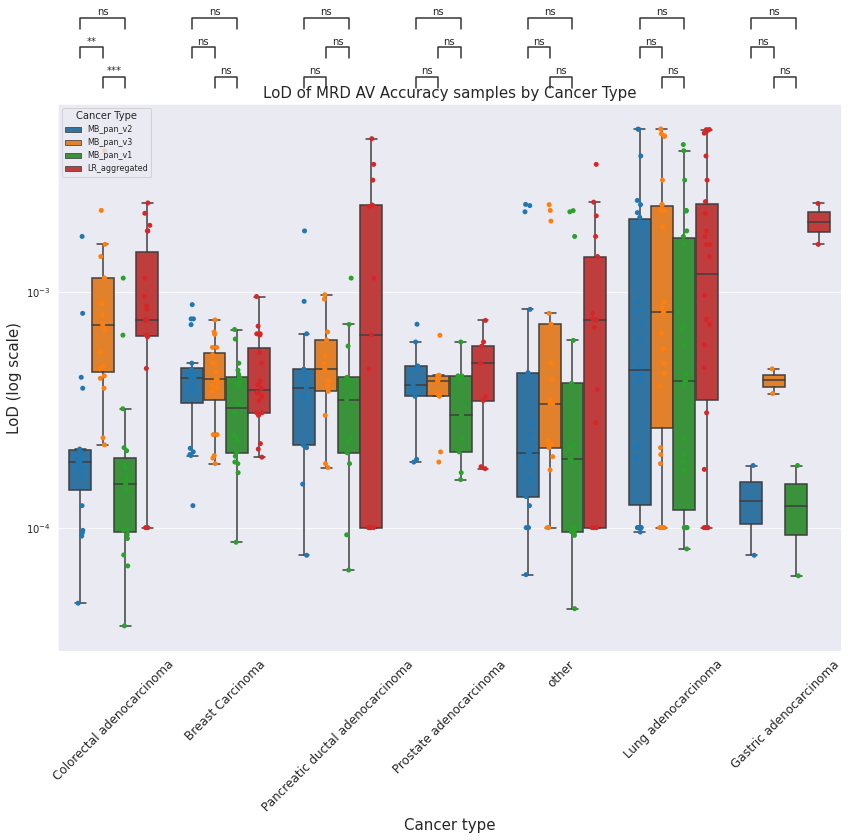

In [78]:
def boxplot_LoD_cancer_acc_new(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="cancer_type", y="LoD", hue="Caller_Type", ax=ax0, palette=palette, showfliers=False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="cancer_type", y="LoD", hue="Caller_Type", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log")
    
    # Statistical analysis for each cancer type and caller type
    for cancer_type, group in df.groupby('cancer_type'):
        for caller_type, subgroup in group.groupby('Caller_Type'):
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup)-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{cancer_type} - {caller_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    # Defining new pairs for within cancer type caller comparison
    cancer_types = df['cancer_type'].unique()
    caller_types = ["MB_pan_v1", "MB_pan_v2", "MB_pan_v3"]  
    
    pairs = []
    for cancer_type in cancer_types:
        for i in range(len(caller_types) - 1):
            for j in range(i + 1, len(caller_types)):
                pairs.append(((cancer_type, caller_types[i]), (cancer_type, caller_types[j])))
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='cancer_type', y='LoD', hue='Caller_Type')
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of MRD AV Accuracy samples by Cancer Type', fontsize=15)
    ax0.set_xlabel('Cancer type', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, fontsize=12)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    # Adjusting legend to display only a subset for clarity
    ax0.legend(unique_handles[:len(caller_types) * len(cancer_types)], unique_labels[:len(caller_types) * len(cancer_types)], title='Cancer Type', loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

boxplot_LoD_cancer_acc_new(df_lod_acc_plot)